# Testing PCA

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append("../")
sys.path.append("../FinRL")

import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt
import random
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3 import TD3
from stable_baselines3.common.logger import configure
from pyfolio import timeseries
from tabulate import tabulate

In [2]:
from finrl.agents.stablebaselines3.models import DRLAgent, DRLEnsembleAgent
from finrl.meta.preprocessor.preprocessors import data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, trx_plot

#### Configs

In [3]:
from finrl.config import (
    TRAINED_MODEL_DIR,
    RESULTS_DIR
)

from Config.local_config import (
    TRAIN_START_DATE,
    TRAIN_END_DATE,

    TRADE_START_DATE,
    TRADE_END_DATE
)

import Config.model_kwargs_config as model_kwargs

In [4]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

# Test 1

## Environments

In [6]:
def create_env(data):
    train = data_split(data, TRAIN_START_DATE,TRAIN_END_DATE)
    trade = data_split(data, TRADE_START_DATE,TRADE_END_DATE)

    stock_dimension = len(train.tic.unique())
    state_space = 1 + 2 * stock_dimension + len(data.columns[9:-2]) * stock_dimension

    num_stock_shares = [0] * stock_dimension
    buy_cost_list = sell_cost_list = [0.001] * stock_dimension

    env_kwargs1 = {
        'hmax': 100,
        "initial_amount": 1000000,
        "num_stock_shares": num_stock_shares,
        "buy_cost_pct": buy_cost_list,
        "sell_cost_pct": sell_cost_list,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": data.columns[9:-2],
        "action_space": stock_dimension,
        "reward_scaling": 1e-4
    }

    e_train_gym = StockTradingEnv(df = train, **env_kwargs1)
    e_trade_gym_out_of_sample = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs1)
    e_trade_gym_in_sample = StockTradingEnv(df = train, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs1)
    
    training_env, _ = e_train_gym.get_sb_env()

    return training_env, e_trade_gym_out_of_sample, e_trade_gym_in_sample

#### PCA .99

In [44]:
Data99 = pd.read_csv("../Datasets/PCA/Dow_Pca_0.99.csv")
train_env_99, e_trade_env_99_outSample,  e_trade_env_99_inSample = create_env(Data99)

#### PCA .95

In [7]:
Data95 = pd.read_csv("../Datasets/PCA/Dow_Pca_0.95.csv")
train_env_95, e_trade_env_95_outSample,  e_trade_env_95_inSample = create_env(Data95)

#### PCA .90

In [8]:
Data90 = pd.read_csv("../Datasets/PCA/Dow_Pca_0.9.csv")
train_env_90, e_trade_env_90_outSample,  e_trade_env_90_inSample = create_env(Data90)

#### PCA .85

In [9]:
Data85 = pd.read_csv("../Datasets/PCA/Dow_Pca_0.85.csv")
train_env_85, e_trade_env_85_outSample,  e_trade_env_85_inSample = create_env(Data85)

#### PCA .80

In [10]:
Data80 = pd.read_csv("../Datasets/PCA/Dow_Pca_0.8.csv")
train_env_80, e_trade_env_80_outSample,  e_trade_env_80_inSample = create_env(Data80)

#### PCA .75

In [11]:
Data75 = pd.read_csv("../Datasets/PCA/Dow_Pca_0.75.csv")
train_env_75, e_trade_env_75_outSample,  e_trade_env_75_inSample = create_env(Data75)

#### PCA .70

In [12]:
Data70 = pd.read_csv("../Datasets/PCA/Dow_Pca_0.7.csv")
train_env_70, e_trade_env_70_outSample,  e_trade_env_70_inSample = create_env(Data70)

### No PCA


In [13]:
DataNoPCA = pd.read_csv("../Datasets/DOWIndicatorData.csv")
train_env, e_trade_env_outSample,  e_trade_env_inSample = create_env(DataNoPCA)

## Training

In [25]:
def logger(alg, model):
    # set up logger
    tmp_path =  "PCA_test_models/tensorboard_log/" + alg
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model.set_logger(new_logger)
    return model

In [26]:
def save_model(trained, alg):
    trained.save("PCA_test_models/trained_models/" + alg)

### A2C

#### A2C 0.99

In [17]:
for i in range(5):
    agent = DRLAgent(env = train_env_99)
    A2C99_model = agent.get_model("a2c")
    A2C99_model = logger("A2C_99", A2C99_model)
    trained_A2C99 = agent.train_model(model=A2C99_model, tb_log_name='A2C_99', total_timesteps=10000)
    save_model(trained_A2C99, f"A2C/A2C_99/iter_{i+1}")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to PCA_test_models/tensorboard_log/A2C_99
---------------------------------------
| time/                 |             |
|    fps                | 81          |
|    iterations         | 100         |
|    time_elapsed       | 6           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.1       |
|    explained_variance | -0.345      |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -52.6       |
|    reward             | -0.09604255 |
|    std                | 0.999       |
|    value_loss         | 3.43        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 82        |
|    iterations         | 200       |
|    time_elapsed       | 12        |
|    total_timesteps    | 1000      |
| train

#### A2C 0.95

In [18]:
for i in range(5):
    agent = DRLAgent(env = train_env_95)
    A2C95_model = agent.get_model("a2c")
    A2C95_model = logger("A2C_95", A2C95_model)
    trained_A2C95 = agent.train_model(model=A2C95_model, tb_log_name='A2C_95', total_timesteps=10000)
    save_model(trained_A2C95, f"A2C/A2C_95/iter_{i+1}")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to PCA_test_models/tensorboard_log/A2C_95
---------------------------------------
| time/                 |             |
|    fps                | 99          |
|    iterations         | 100         |
|    time_elapsed       | 5           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.3       |
|    explained_variance | -0.0803     |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -64.9       |
|    reward             | 0.057299085 |
|    std                | 1           |
|    value_loss         | 3.4         |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 104       |
|    iterations         | 200       |
|    time_elapsed       | 9         |
|    total_timesteps    | 1000      |
| train

#### A2C 0.90

In [19]:
for i in range(5):
    agent = DRLAgent(env = train_env_90)
    A2C90_model = agent.get_model("a2c")
    A2C90_model = logger("A2C_90", A2C90_model)
    trained_A2C90 = agent.train_model(model=A2C90_model, tb_log_name='A2C_90', total_timesteps=10000)
    save_model(trained_A2C90, f"A2C/A2C_90/iter_{i+1}")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to PCA_test_models/tensorboard_log/A2C_90
--------------------------------------
| time/                 |            |
|    fps                | 101        |
|    iterations         | 100        |
|    time_elapsed       | 4          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -25.7      |
|    reward             | -0.5639547 |
|    std                | 1          |
|    value_loss         | 0.523      |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 104       |
|    iterations         | 200       |
|    time_elapsed       | 9         |
|    total_timesteps    | 1000      |
| train/               

#### A2C 0.85

In [20]:
for i in range(5):
    agent = DRLAgent(env = train_env_85)
    A2C85_model = agent.get_model("a2c")
    A2C85_model = logger("A2C_85", A2C85_model)
    trained_A2C85 = agent.train_model(model=A2C85_model, tb_log_name='A2C_85', total_timesteps=10000)
    save_model(trained_A2C85, f"A2C/A2C_85/iter_{i+1}")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to PCA_test_models/tensorboard_log/A2C_85
---------------------------------------
| time/                 |             |
|    fps                | 132         |
|    iterations         | 100         |
|    time_elapsed       | 3           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.3       |
|    explained_variance | -0.0463     |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -119        |
|    reward             | 0.047672164 |
|    std                | 1           |
|    value_loss         | 9.8         |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 135        |
|    iterations         | 200        |
|    time_elapsed       | 7          |
|    total_timesteps    | 1000       |
|

#### A2C 0.80

In [21]:
for i in range(5):
    agent = DRLAgent(env = train_env_80)
    A2C80_model = agent.get_model("a2c")
    A2C80_model = logger("A2C_80", A2C80_model)
    trained_A2C80 = agent.train_model(model=A2C80_model, tb_log_name='A2C_80', total_timesteps=10000)
    save_model(trained_A2C80, f"A2C/A2C_80/iter_{i+1}")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to PCA_test_models/tensorboard_log/A2C_80
------------------------------------
| time/                 |          |
|    fps                | 143      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -41.2    |
|    explained_variance | -0.0365  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -19.9    |
|    reward             | -1.25808 |
|    std                | 1        |
|    value_loss         | 0.703    |
------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 143          |
|    iterations         | 200          |
|    time_elapsed       | 6            |
|    total_timesteps    | 1000         |
| train/                |            

#### A2C 0.75

In [22]:
for i in range(5):
    agent = DRLAgent(env = train_env_75)
    A2C75_model = agent.get_model("a2c")
    A2C75_model = logger("A2C_75", A2C75_model)
    trained_A2C75 = agent.train_model(model=A2C75_model, tb_log_name='A2C_75', total_timesteps=10000)
    save_model(trained_A2C75, f"A2C/A2C_75/iter_{i+1}")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to PCA_test_models/tensorboard_log/A2C_75
---------------------------------------
| time/                 |             |
|    fps                | 140         |
|    iterations         | 100         |
|    time_elapsed       | 3           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.3       |
|    explained_variance | 0.501       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -39.7       |
|    reward             | -0.04995377 |
|    std                | 1           |
|    value_loss         | 0.974       |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 143       |
|    iterations         | 200       |
|    time_elapsed       | 6         |
|    total_timesteps    | 1000      |
| train

#### A2C 0.7

In [23]:
for i in range(5):    
    agent = DRLAgent(env = train_env_70)
    A2C70_model = agent.get_model("a2c")
    A2C70_model = logger("A2C_70", A2C70_model)
    trained_A2C70 = agent.train_model(model=A2C70_model, tb_log_name='A2C_70', total_timesteps=10000)
    save_model(trained_A2C70, f"A2C/A2C_70/iter_{i+1}")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to PCA_test_models/tensorboard_log/A2C_70
-------------------------------------
| time/                 |           |
|    fps                | 115       |
|    iterations         | 100       |
|    time_elapsed       | 4         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0.000975  |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -41       |
|    reward             | 0.1318937 |
|    std                | 1         |
|    value_loss         | 1.29      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 121        |
|    iterations         | 200        |
|    time_elapsed       | 8          |
|    total_timesteps    | 1000       |
| train/                |        

#### No PCA

In [49]:
for i in range(5):    
    agent = DRLAgent(env = train_env)
    A2C_No_PCA_model = agent.get_model("a2c")
    A2C_No_PCA_model = logger("A2C_No_PCA", A2C_No_PCA_model)
    trained_A2C_No_PCA = agent.train_model(model=A2C_No_PCA_model, tb_log_name='A2C_No_PCA', total_timesteps=10000)
    save_model(trained_A2C_No_PCA, f"A2C/A2C_No_PCA/iter_{i+1}")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to PCA_test_models/tensorboard_log/A2C_No_PCA
--------------------------------------
| time/                 |            |
|    fps                | 52         |
|    iterations         | 100        |
|    time_elapsed       | 9          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | -0.932     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -60.1      |
|    reward             | -0.8126685 |
|    std                | 1          |
|    value_loss         | 2.75       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 65        |
|    iterations         | 200       |
|    time_elapsed       | 15        |
|    total_timesteps    | 1000      |
| train/           

### PPO



#### PPO 0.99

In [25]:
for i in range(5):   
    agent = DRLAgent(env = train_env_99)
    PPO99_model = agent.get_model("ppo")
    PPO99_model = logger("PPO_99", PPO99_model)
    trained_PPO99 = agent.train_model(model=PPO99_model, tb_log_name='PPO_99', total_timesteps=10000)
    save_model(trained_PPO99, f"PPO/PPO_99/iter_{i+1}")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to PCA_test_models/tensorboard_log/PPO_99
-----------------------------------
| time/              |            |
|    fps             | 76         |
|    iterations      | 1          |
|    time_elapsed    | 26         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.29082477 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 79          |
|    iterations           | 2           |
|    time_elapsed         | 51          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.01707079  |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.0114      |
|    learning_rate       

#### PPO 0.95

In [26]:
for i in range(5): 
    agent = DRLAgent(env = train_env_95)
    PPO95_model = agent.get_model("ppo")
    PPO95_model = logger("PPO_95", PPO95_model)
    trained_PPO95 = agent.train_model(model=PPO95_model, tb_log_name='PPO_95', total_timesteps=10000)
    save_model(trained_PPO95, f"PPO/PPO_95/iter_{i+1}")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to PCA_test_models/tensorboard_log/PPO_95
-----------------------------------
| time/              |            |
|    fps             | 78         |
|    iterations      | 1          |
|    time_elapsed    | 26         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.24542479 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 2           |
|    time_elapsed         | 49          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020324847 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0356     |
|    learning_rate       

#### PPO 0.90

In [27]:
for i in range(5): 
    agent = DRLAgent(env = train_env_90)
    PPO90_model = agent.get_model("ppo")
    PPO90_model = logger("PPO_90", PPO90_model)
    trained_PPO90 = agent.train_model(model=PPO90_model, tb_log_name='PPO_90', total_timesteps=10000)
    save_model(trained_PPO90, f"PPO/PPO_90/iter_{i+1}")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to PCA_test_models/tensorboard_log/PPO_90
-----------------------------------
| time/              |            |
|    fps             | 151        |
|    iterations      | 1          |
|    time_elapsed    | 13         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.31949547 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 145         |
|    iterations           | 2           |
|    time_elapsed         | 28          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.02157066  |
|    clip_fraction        | 0.259       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.0193      |
|    learning_rate       

#### PPO 0.85

In [28]:
for i in range(5): 
    agent = DRLAgent(env = train_env_85)
    PPO85_model = agent.get_model("ppo")
    PPO85_model = logger("PPO_85", PPO85_model)
    trained_PPO85 = agent.train_model(model=PPO85_model, tb_log_name='PPO_85', total_timesteps=10000)
    save_model(trained_PPO85, f"PPO/PPO_85/iter_{i+1}")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to PCA_test_models/tensorboard_log/PPO_85
----------------------------------
| time/              |           |
|    fps             | 144       |
|    iterations      | 1         |
|    time_elapsed    | 14        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.2906793 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 142         |
|    iterations           | 2           |
|    time_elapsed         | 28          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017452057 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.0162      |
|    learning_rate        | 0.0002

#### PPO 0.80

In [29]:
for i in range(5):     
    agent = DRLAgent(env = train_env_80)
    PPO80_model = agent.get_model("ppo")
    PPO80_model = logger("PPO_80", PPO80_model)
    trained_PPO80 = agent.train_model(model=PPO80_model, tb_log_name='PPO_80', total_timesteps=10000)
    save_model(trained_PPO80, f"PPO/PPO_80/iter_{i+1}")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to PCA_test_models/tensorboard_log/PPO_80
-----------------------------------
| time/              |            |
|    fps             | 151        |
|    iterations      | 1          |
|    time_elapsed    | 13         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.35071447 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 145         |
|    iterations           | 2           |
|    time_elapsed         | 28          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019143239 |
|    clip_fraction        | 0.25        |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.1       |
|    explained_variance   | 0.00222     |
|    learning_rate       

#### PPO 0.75

In [30]:
for i in range(5): 
    agent = DRLAgent(env = train_env_75)
    PPO75_model = agent.get_model("ppo")
    PPO75_model = logger("PPO_75", PPO75_model)
    trained_PPO75 = agent.train_model(model=PPO75_model, tb_log_name='PPO_75', total_timesteps=10000)
    save_model(trained_PPO75, f"PPO/PPO_75/iter_{i+1}")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to PCA_test_models/tensorboard_log/PPO_75
-----------------------------------
| time/              |            |
|    fps             | 141        |
|    iterations      | 1          |
|    time_elapsed    | 14         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.35928768 |
-----------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 138          |
|    iterations           | 2            |
|    time_elapsed         | 29           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.020876504  |
|    clip_fraction        | 0.261        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | -0.0223      |
|    learning

#### PPO 0.70

In [31]:
for i in range(5): 
    agent = DRLAgent(env = train_env_70)
    PPO70_model = agent.get_model("ppo")
    PPO70_model = logger("PPO_70", PPO70_model)
    trained_PPO70 = agent.train_model(model=PPO70_model, tb_log_name='PPO_70', total_timesteps=10000)
    save_model(trained_PPO70, f"PPO/PPO_70/iter_{i+1}")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to PCA_test_models/tensorboard_log/PPO_70
-----------------------------------
| time/              |            |
|    fps             | 146        |
|    iterations      | 1          |
|    time_elapsed    | 13         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.32896262 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 140         |
|    iterations           | 2           |
|    time_elapsed         | 29          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020422675 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.022      |
|    learning_rate       

#### No PCA

In [32]:
for i in range(5): 
    agent = DRLAgent(env = train_env)
    PPO_No_PCA_model = agent.get_model("ppo")
    PPO_No_PCA_model = logger("PPO_No_PCA", PPO_No_PCA_model)
    trained_PPO_No_PCA = agent.train_model(model=PPO_No_PCA_model, tb_log_name='PPO_No_PCA', total_timesteps=10000)
    save_model(trained_PPO_No_PCA, f"PPO/PPO_No_PCA/iter_{i+1}")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to PCA_test_models/tensorboard_log/PPO_No_PCA
-----------------------------------
| time/              |            |
|    fps             | 99         |
|    iterations      | 1          |
|    time_elapsed    | 20         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.37711346 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 2           |
|    time_elapsed         | 41          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017865319 |
|    clip_fraction        | 0.263       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.00672     |
|    learning_rate   

### TD3

#### TD3 0.99

In [22]:
for i in range(5):   
    agent = DRLAgent(env = train_env_99)
    TD399_model = agent.get_model("td3")
    TD399_model = logger("TD3_99", TD399_model)
    trained_TD399 = agent.train_model(model=TD399_model, tb_log_name='TD3_99', total_timesteps=10000)
    save_model(trained_TD399, f"TD3/TD3_99/iter_{i+1}")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_99
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 41         |
|    time_elapsed    | 193        |
|    total_timesteps | 8052       |
| train/             |            |
|    actor_loss      | 22.8       |
|    critic_loss     | 959        |
|    learning_rate   | 0.001      |
|    n_updates       | 6039       |
|    reward          | -1.3522823 |
-----------------------------------
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_99
day: 2012, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 2825133.72
total_reward: 1825133.72
total_cost: 1344.05
total_trades: 24218
Sharpe: 0.878
-----------------------------------
| time/              |            |
|    episodes        | 4      

#### TD3 0.95

In [23]:
for i in range(5):   
    agent = DRLAgent(env = train_env_95)
    TD395_model = agent.get_model("td3")
    TD395_model = logger("TD3_95", TD395_model)
    trained_TD395 = agent.train_model(model=TD395_model, tb_log_name='TD3_95', total_timesteps=10000)
    save_model(trained_TD395, f"TD3/TD3_95/iter_{i+1}")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_95
------------------------------------
| time/              |             |
|    episodes        | 4           |
|    fps             | 42          |
|    time_elapsed    | 187         |
|    total_timesteps | 8052        |
| train/             |             |
|    actor_loss      | 48.2        |
|    critic_loss     | 971         |
|    learning_rate   | 0.001       |
|    n_updates       | 6039        |
|    reward          | -0.99863124 |
------------------------------------
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_95
day: 2012, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 3089361.37
total_reward: 2089361.37
total_cost: 1060.87
total_trades: 34185
Sharpe: 1.069
-----------------------------------
| time/              |            |
|    episodes    

#### TD3 0.90

In [18]:
for i in range(5):   
    agent = DRLAgent(env = train_env_90)
    TD390_model = agent.get_model("td3")
    TD390_model = logger("TD3_90", TD390_model)
    trained_TD390 = agent.train_model(model=TD390_model, tb_log_name='TD3_90', total_timesteps=10000)
    save_model(trained_TD390, f"TD3/TD3_90/iter_{i+1}")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_90
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 45         |
|    time_elapsed    | 176        |
|    total_timesteps | 8052       |
| train/             |            |
|    actor_loss      | 88         |
|    critic_loss     | 21.8       |
|    learning_rate   | 0.001      |
|    n_updates       | 6039       |
|    reward          | -1.2283418 |
-----------------------------------
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_90
day: 2012, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 3228581.12
total_reward: 2228581.12
total_cost: 1076.87
total_trades: 30216
Sharpe: 1.058
-----------------------------------
| time/              |            |
|    episodes        | 4      

#### TD3 0.85

In [17]:
for i in range(5):   
    agent = DRLAgent(env = train_env_85)
    TD385_model = agent.get_model("td3")
    TD385_model = logger("TD3_85", TD385_model)
    trained_TD385 = agent.train_model(model=TD385_model, tb_log_name='TD3_85', total_timesteps=10000)
    save_model(trained_TD385, f"TD3/TD3_85/iter_{i+1}")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_85
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 45         |
|    time_elapsed    | 176        |
|    total_timesteps | 8052       |
| train/             |            |
|    actor_loss      | -15.8      |
|    critic_loss     | 2.52e+03   |
|    learning_rate   | 0.001      |
|    n_updates       | 6039       |
|    reward          | -1.6179562 |
-----------------------------------
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_85
day: 2012, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 3166058.55
total_reward: 2166058.55
total_cost: 999.00
total_trades: 24144
Sharpe: 1.028
-----------------------------------
| time/              |            |
|    episodes        | 4       

#### TD3 0.80

In [16]:
for i in range(5):   
    agent = DRLAgent(env = train_env_80)
    TD380_model = agent.get_model("td3")
    TD380_model = logger("TD3_80", TD380_model)
    trained_TD380 = agent.train_model(model=TD380_model, tb_log_name='TD3_80', total_timesteps=10000)
    save_model(trained_TD380, f"TD3_80/iter_{i+1}")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_80
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 35         |
|    time_elapsed    | 225        |
|    total_timesteps | 8052       |
| train/             |            |
|    actor_loss      | 288        |
|    critic_loss     | 2.76e+04   |
|    learning_rate   | 0.001      |
|    n_updates       | 6039       |
|    reward          | -1.0401176 |
-----------------------------------
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_80
day: 2012, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 3067778.88
total_reward: 2067778.88
total_cost: 999.00
total_trades: 28116
Sharpe: 1.044
-----------------------------------
| time/              |            |
|    episodes        | 4       

#### TD3 0.75

In [19]:
for i in range(5):   
    agent = DRLAgent(env = train_env_75)
    TD375_model = agent.get_model("td3")
    TD375_model = logger("TD3_75", TD375_model)
    trained_TD375 = agent.train_model(model=TD375_model, tb_log_name='TD3_75', total_timesteps=10000)
    save_model(trained_TD375, f"TD3/TD3_75/iter_{i+1}")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_75
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 45         |
|    time_elapsed    | 176        |
|    total_timesteps | 8052       |
| train/             |            |
|    actor_loss      | 99.4       |
|    critic_loss     | 2.68e+03   |
|    learning_rate   | 0.001      |
|    n_updates       | 6039       |
|    reward          | -1.5596261 |
-----------------------------------
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_75
day: 2012, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 2939718.34
total_reward: 1939718.34
total_cost: 1146.34
total_trades: 34237
Sharpe: 0.966
-----------------------------------
| time/              |            |
|    episodes        | 4      

#### TD3 0.70

In [20]:
for i in range(5):   
    agent = DRLAgent(env = train_env_70)
    TD370_model = agent.get_model("td3")
    TD370_model = logger("TD3_70", TD370_model)
    trained_TD370 = agent.train_model(model=TD370_model, tb_log_name='TD3_70', total_timesteps=10000)
    save_model(trained_TD370, f"TD3/TD3_70/iter_{i+1}")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_70
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 54         |
|    time_elapsed    | 148        |
|    total_timesteps | 8052       |
| train/             |            |
|    actor_loss      | 90.8       |
|    critic_loss     | 7.65e+03   |
|    learning_rate   | 0.001      |
|    n_updates       | 6039       |
|    reward          | -1.1737225 |
-----------------------------------
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_70
day: 2012, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 2790301.98
total_reward: 1790301.98
total_cost: 1086.91
total_trades: 32252
Sharpe: 0.990
-----------------------------------
| time/              |            |
|    episodes        | 4      

#### TD3 No PCA

In [21]:
for i in range(5):   
    agent = DRLAgent(env = train_env)
    TD3_No_PCA_model = agent.get_model("td3")
    TD3_No_PCA_model = logger("TD3_No_PCA", TD3_No_PCA_model)
    trained_TD3_No_PCA = agent.train_model(model=TD3_No_PCA_model, tb_log_name='TD3_No_PCA', total_timesteps=10000)
    save_model(trained_TD3_No_PCA, f"TD3/TD3_No_PCA/iter_{i+1}")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_No_PCA
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 35        |
|    time_elapsed    | 224       |
|    total_timesteps | 8052      |
| train/             |           |
|    actor_loss      | -32.6     |
|    critic_loss     | 1.66e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 6039      |
|    reward          | -1.314217 |
----------------------------------
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_No_PCA
day: 2012, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 2512056.77
total_reward: 1512056.77
total_cost: 1061.29
total_trades: 32207
Sharpe: 0.865
-----------------------------------
| time/              |            |
|    episodes        | 4          |

## Evaluation

### Helper Functions

In [18]:
def sample_perf(modelIn, tradingEnv):
    trained_moedl = modelIn
    df_account_value, df_actions = DRLAgent.DRL_prediction(
        model=trained_moedl, 
        environment = tradingEnv)
    return df_account_value, df_actions 

In [19]:
def states(account_value_dict, value_col_name="account_value"):
    data = [
        ["Annual return"],
        ["Cumulative returns"],
        ["Annual volatility"],
        ["Sharpe ratio"],
        ["Calmar ratio"],
        ["Stability"],
        ["Max drawdown"],
        ["Omega ratio"],
        ["Sortino ratio"],
        ["Tail ratio"],
        ["Daily value at risk"]
    ]

    temp_data = {
        "Annual return" : 0,
        "Cumulative returns" : 0,
        "Annual volatility" : 0,
        "Sharpe ratio" : 0,
        "Calmar ratio" : 0,
        "Stability" : 0,
        "Max drawdown" : 0,
        "Omega ratio" : 0,
        "Sortino ratio" : 0,
        "Tail ratio" : 0,
        "Daily value at risk" : 0,
    }

    best_indexs = []

    counter = 1
    for key in account_value_dict.keys():
        
        dr_test = get_daily_return(account_value_dict[key], value_col_name=value_col_name)
        perf_stats_all = timeseries.perf_stats(
            returns=dr_test,
            positions=None,
            transactions=None,
            turnover_denom="AGB",
        )

        if temp_data["Sharpe ratio"] < perf_stats_all[3]:
            best_index = counter - 1
            for index, row in perf_stats_all.iteritems():
                if index != "Skew" and index != "Kurtosis":
                    temp_data[index] = row
        # print(key)
        if (counter % 5 == 0 and counter != 0) or counter == len(account_value_dict.keys()):
            pos_counter = 0
            # print("-----")
            for row in temp_data:
                if row != "Skew" and row != "Kurtosis":
                    data[pos_counter].append(round(temp_data[row], 4))
                    pos_counter += 1
            temp_data = temp_data.fromkeys(temp_data, 0)
            best_indexs.append(best_index)
        counter += 1

    return data, best_indexs 

In [20]:
def load_models(dirs, alg_loader, alg):
    return_models = []
    
    for d in dirs:
        alg_models = []
        for i in range(5):
            alg_models.append(alg_loader.load(f"PCA_test_models/trained_models/{alg}/{d}/iter_{i+1}"))
        return_models.append(alg_models)
    
    return return_models

In [21]:
def group_sample_perf(models, model_names, environments):
    return_dict = {}
    to_be_averaged = []
    total = 0
    for alg in range(len(models)):
        for model in range(len(models[alg])):
            account_value, actions = sample_perf(models[alg][model], environments[alg])
            return_dict[f"{model_names[alg]}_{model}"] = account_value
            
    return return_dict

In [22]:
import empyrical as ep
import seaborn as sns
from copy import deepcopy
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

def plot_cumulative_returns(account_values, alg_names):
    colors = sns.color_palette("bright")
    counter = 0
    for i in account_values:
        df = deepcopy(account_values[i])
        df["date"] = pd.to_datetime(df["date"])
        bt_returns = get_daily_return(df, value_col_name="account_value")

        cum_rets = ep.cum_returns(bt_returns, 1.0)
        # print(bt_returns)
    
        plt.plot(cum_rets.index, cum_rets.values, color = colors[counter], label = f"PCA {alg_names[counter]}")
        counter += 1
    

    DJI_value = YahooDownloader(
        start_date=df.loc[0,'date'], 
        end_date=df.loc[len(account_values[alg_names[0]])-1,'date'], 
        ticker_list=['^DJI']
    ).fetch_data()
    DJI_value["date"] = pd.to_datetime(DJI_value["date"], format="%Y-%m-%d")
    DJI_value = pd.merge(df[["date"]], DJI_value, how="left", on="date")
    DJI_value = DJI_value.fillna(method="ffill").fillna(method="bfill")
    benchmark_rets = get_daily_return(DJI_value, value_col_name="close")
    benchmark_rets.name = "DJI"


    cum_factor_returns = ep.cum_returns(benchmark_rets[cum_rets.index], 1.0)
    # print(benchmark_rets)
    plt.plot(cum_factor_returns.index, cum_factor_returns.values, label = "DOW", color = 'black')
    
    plt.grid()
    plt.ylabel('Cumulative returns')
    plt.xlabel('Date')
    plt.legend()
    plt.show()

In [ ]:
in_sample_envs = [e_trade_env_99_inSample, e_trade_env_95_inSample, e_trade_env_90_inSample, e_trade_env_85_inSample, e_trade_env_80_inSample, e_trade_env_75_inSample, e_trade_env_70_inSample, e_trade_env_inSample]
out_of_sample_envs = [e_trade_env_99_outSample, e_trade_env_95_outSample, e_trade_env_90_outSample, e_trade_env_85_outSample, e_trade_env_80_outSample, e_trade_env_75_outSample, e_trade_env_70_outSample, e_trade_env_outSample]

### A2C

In [20]:
A2C_model_names = ["A2C_99", "A2C_95", "A2C_90", "A2C_85", "A2C_80", "A2C_75", "A2C_70", "A2C_No_PCA"]
A2C_models = load_models(A2C_model_names, A2C, "A2C")

In [21]:
# In sample
with suppress_stdout():
    results_dict_inSample = group_sample_perf(A2C_models, A2C_model_names, in_sample_envs)

In [22]:
# Out of sample
with suppress_stdout():
    results_dict_outSample = group_sample_perf(A2C_models, A2C_model_names, out_of_sample_envs)

In [24]:
print("Out Of Sample Results")
data, outSample_best_indexs = states(results_dict_outSample)
print(tabulate(data, A2C_model_names, tablefmt="outline"))

print("In Sample Results")
data2, inSample_best_indexs = states(results_dict_inSample)
print(tabulate(data2, A2C_model_names, tablefmt="outline"))

Out Of Sample Results
+---------------------+----------+----------+----------+----------+----------+----------+----------+--------------+
|                     |   A2C_99 |   A2C_95 |   A2C_90 |   A2C_85 |   A2C_80 |   A2C_75 |   A2C_70 |   A2C_No_PCA |
+=====================+==========+==========+==========+==========+==========+==========+==========+==============+
| Annual return       |   0.129  |   0.1037 |   0.1242 |   0.1416 |   0.1404 |   0.1306 |   0.1481 |       0.1334 |
| Cumulative returns  |   0.4382 |   0.3438 |   0.42   |   0.4869 |   0.4822 |   0.4443 |   0.5124 |       0.4552 |
| Annual volatility   |   0.2285 |   0.1941 |   0.2266 |   0.2261 |   0.2103 |   0.205  |   0.1981 |       0.1916 |
| Sharpe ratio        |   0.6464 |   0.6067 |   0.6317 |   0.7003 |   0.7313 |   0.7025 |   0.7978 |       0.7509 |
| Calmar ratio        |   0.4473 |   0.4079 |   0.4173 |   0.546  |   0.4973 |   0.5395 |   0.5699 |       0.5194 |
| Stability           |   0.6265 |   0.6608 |   0.

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (754, 8)


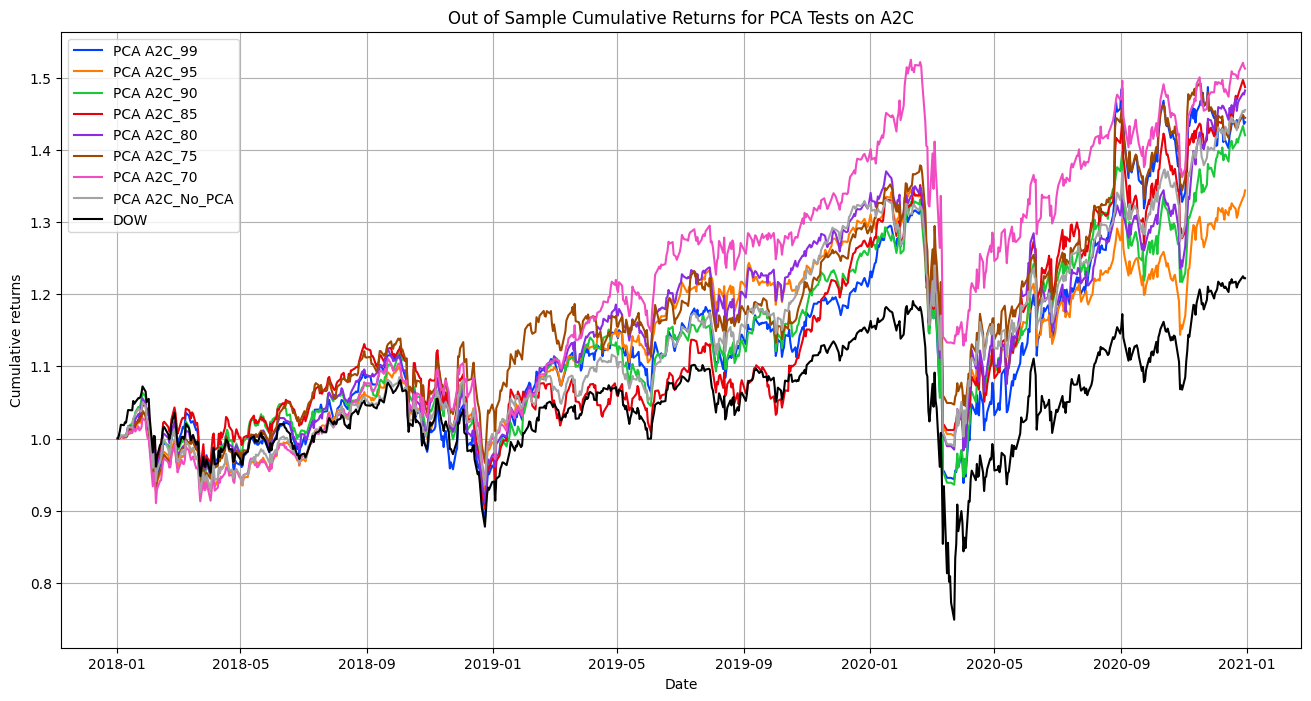

In [25]:
account_values = {}
for i in range(len(A2C_model_names)):
    account_values[A2C_model_names[i]] = results_dict_outSample[list(results_dict_outSample)[outSample_best_indexs[i]]]
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
plt.title("Out of Sample Cumulative Returns for PCA Tests on A2C")
plot_cumulative_returns(account_values, A2C_model_names)
plt.show()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2012, 8)


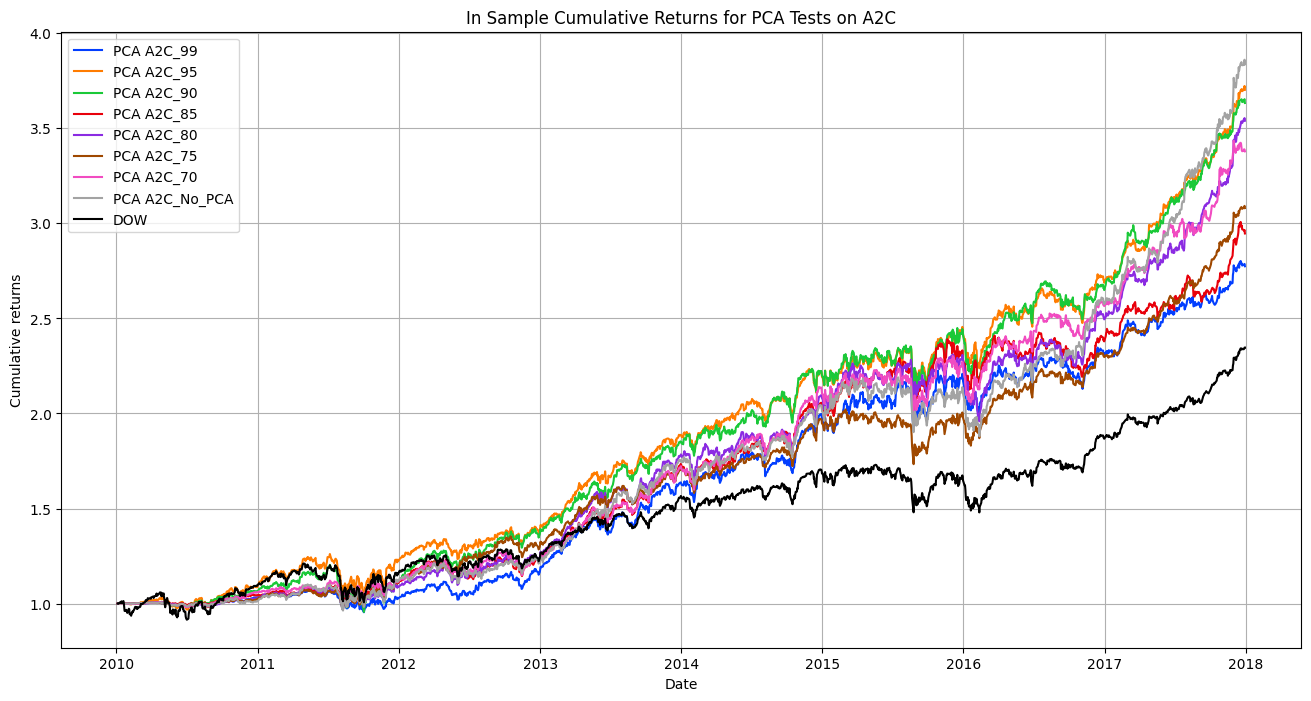

In [33]:
account_values = {}
for i in range(len(A2C_model_names)):
    account_values[A2C_model_names[i]] = results_dict_inSample[list(results_dict_inSample)[inSample_best_indexs[i]]]
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
plt.title("In Sample Cumulative Returns for PCA Tests on A2C")
plot_cumulative_returns(account_values, A2C_model_names)
plt.show()

### PPO

In [27]:
PPO_model_names = ["PPO_99", "PPO_95", "PPO_90", "PPO_85", "PPO_80", "PPO_75", "PPO_70", "PPO_No_PCA"]
PPO_models = load_models(PPO_model_names, PPO, "PPO")

In [28]:
# In sample
with suppress_stdout():
    results_dict_inSample = group_sample_perf(PPO_models, PPO_model_names, in_sample_envs)

# Out of sample
with suppress_stdout():
    results_dict_outSample = group_sample_perf(PPO_models, PPO_model_names, out_of_sample_envs)

In [29]:
data, outSample_best_indexs = states(results_dict_outSample)
print("Out Of Sample Results")
print(tabulate(data, PPO_model_names, tablefmt="outline"))

data, inSample_best_indexs = states(results_dict_inSample)
print("In Sample Results")
print(tabulate(data, PPO_model_names, tablefmt="outline"))

Out Of Sample Results
+---------------------+----------+----------+----------+----------+----------+----------+----------+--------------+
|                     |   PPO_99 |   PPO_95 |   PPO_90 |   PPO_85 |   PPO_80 |   PPO_75 |   PPO_70 |   PPO_No_PCA |
+=====================+==========+==========+==========+==========+==========+==========+==========+==============+
| Annual return       |   0.0609 |   0.0939 |   0.0767 |   0.0908 |   0.0746 |   0.0479 |   0.0753 |       0.0853 |
| Cumulative returns  |   0.1939 |   0.3086 |   0.248  |   0.2976 |   0.2407 |   0.1505 |   0.243  |       0.2778 |
| Annual volatility   |   0.17   |   0.1907 |   0.1627 |   0.1886 |   0.1847 |   0.1485 |   0.1545 |       0.1747 |
| Sharpe ratio        |   0.4344 |   0.5677 |   0.5373 |   0.5568 |   0.4833 |   0.3906 |   0.5484 |       0.5569 |
| Calmar ratio        |   0.2168 |   0.3373 |   0.3045 |   0.344  |   0.2908 |   0.2077 |   0.3293 |       0.3765 |
| Stability           |   0.1979 |   0.3365 |   0.

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (754, 8)


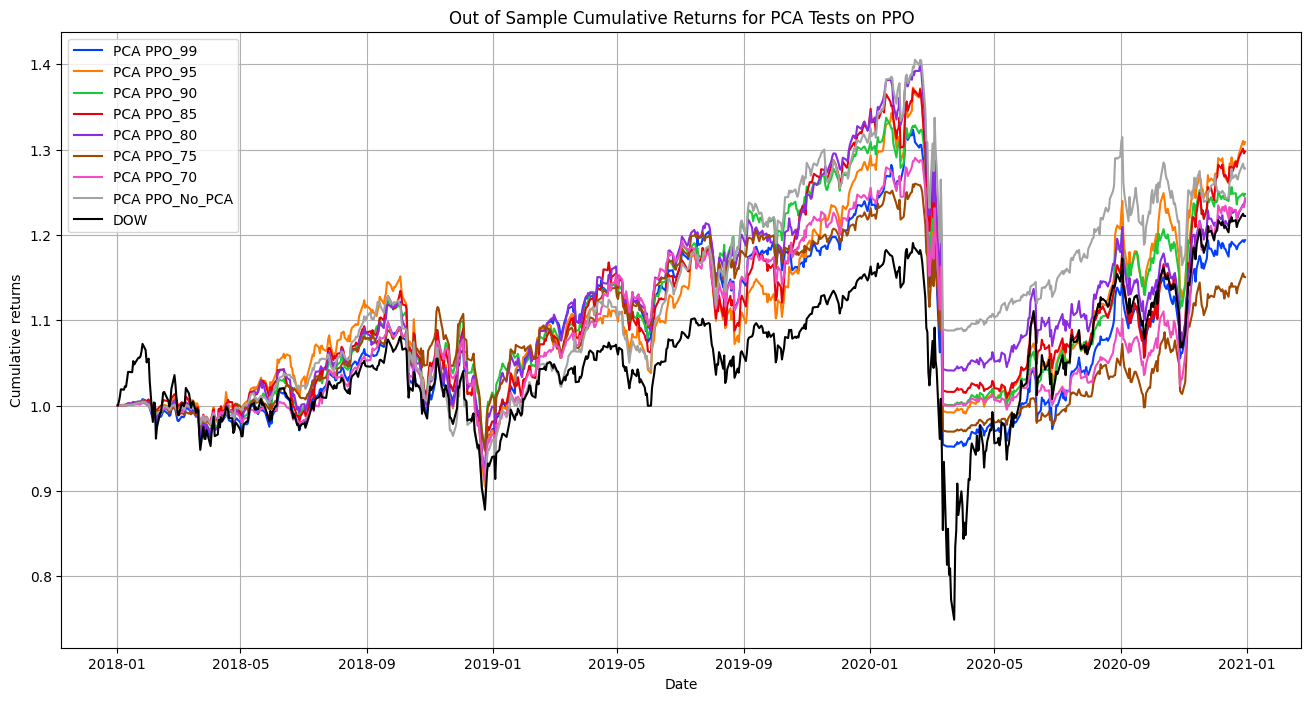

In [30]:
account_values = {}
for i in range(len(PPO_model_names)):
    account_values[PPO_model_names[i]] = results_dict_outSample[list(results_dict_outSample)[outSample_best_indexs[i]]]
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
plt.title("Out of Sample Cumulative Returns for PCA Tests on PPO")
plot_cumulative_returns(account_values, PPO_model_names)
plt.show()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2012, 8)


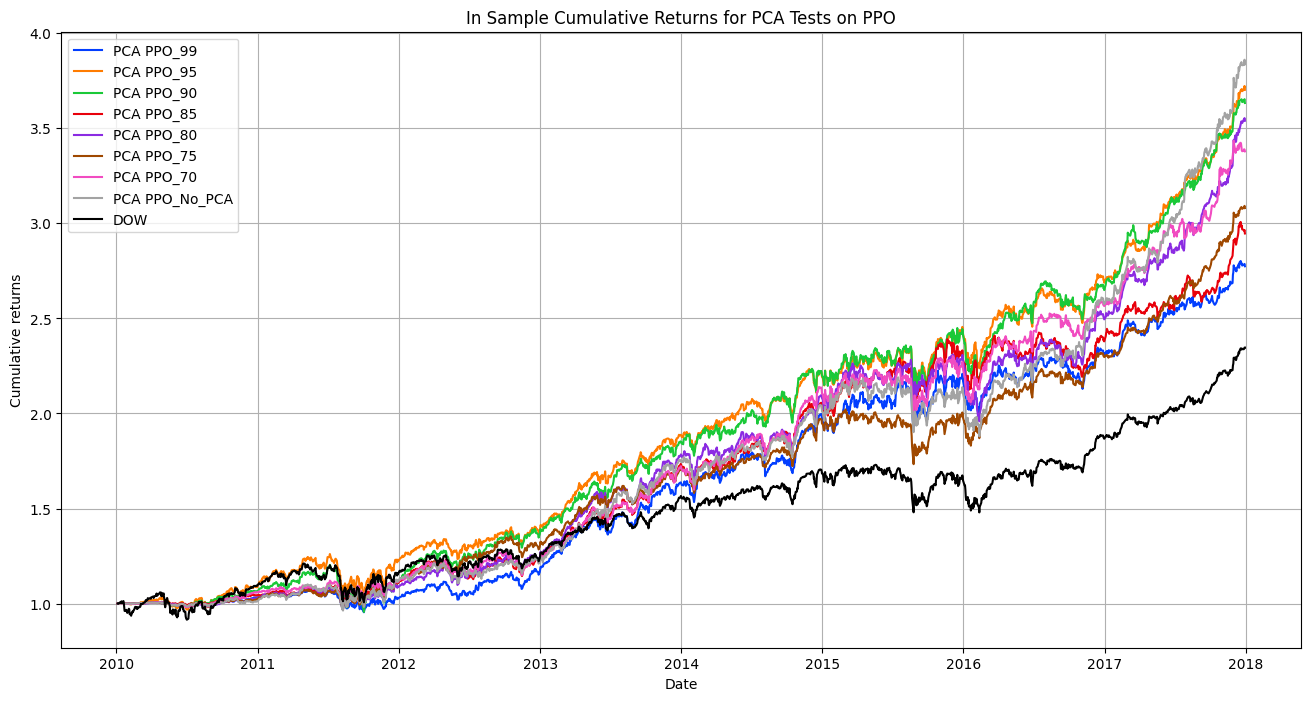

In [32]:
account_values = {}
for i in range(len(PPO_model_names)):
    account_values[PPO_model_names[i]] = results_dict_inSample[list(results_dict_inSample)[inSample_best_indexs[i]]]
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
plt.title("In Sample Cumulative Returns for PCA Tests on PPO")
plot_cumulative_returns(account_values, PPO_model_names)
plt.show()

### TD3

In [20]:
TD3_model_names = ["TD3_99", "TD3_95", "TD3_90", "TD3_85", "TD3_80", "TD3_75", "TD3_70", "TD3_No_PCA"]
TD3_models = load_models(TD3_model_names, TD3, "TD3")

In [21]:
# In sample
with suppress_stdout():
    results_dict_inSample = group_sample_perf(TD3_models, TD3_model_names, in_sample_envs)

# Out of sample
with suppress_stdout():
    results_dict_outSample = group_sample_perf(TD3_models, TD3_model_names, out_of_sample_envs)

In [23]:
data, outSample_best_indexs = states(results_dict_outSample)
print("Out Of Sample Results")
print(tabulate(data, TD3_model_names, tablefmt="outline"))

data2, inSample_best_indexs = states(results_dict_inSample)
print("In Sample Results")
print(tabulate(data2, TD3_model_names, tablefmt="outline"))

Out Of Sample Results
+---------------------+----------+----------+----------+----------+----------+----------+----------+--------------+
|                     |   TD3_99 |   TD3_95 |   TD3_90 |   TD3_85 |   TD3_80 |   TD3_75 |   TD3_70 |   TD3_No_PCA |
+=====================+==========+==========+==========+==========+==========+==========+==========+==============+
| Annual return       |   0.1195 |   0.1124 |   0.1305 |   0.1581 |   0.1338 |   0.1518 |   0.1502 |       0.1361 |
| Cumulative returns  |   0.4026 |   0.3758 |   0.4442 |   0.5524 |   0.4567 |   0.5273 |   0.5208 |       0.4658 |
| Annual volatility   |   0.1922 |   0.2099 |   0.2    |   0.2173 |   0.2069 |   0.2027 |   0.2099 |       0.2004 |
| Sharpe ratio        |   0.6851 |   0.6137 |   0.7149 |   0.7857 |   0.7117 |   0.8003 |   0.7733 |       0.7386 |
| Calmar ratio        |   0.5004 |   0.3844 |   0.4714 |   0.5239 |   0.5032 |   0.5555 |   0.5637 |       0.5414 |
| Stability           |   0.7641 |   0.6431 |   0.

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (754, 8)


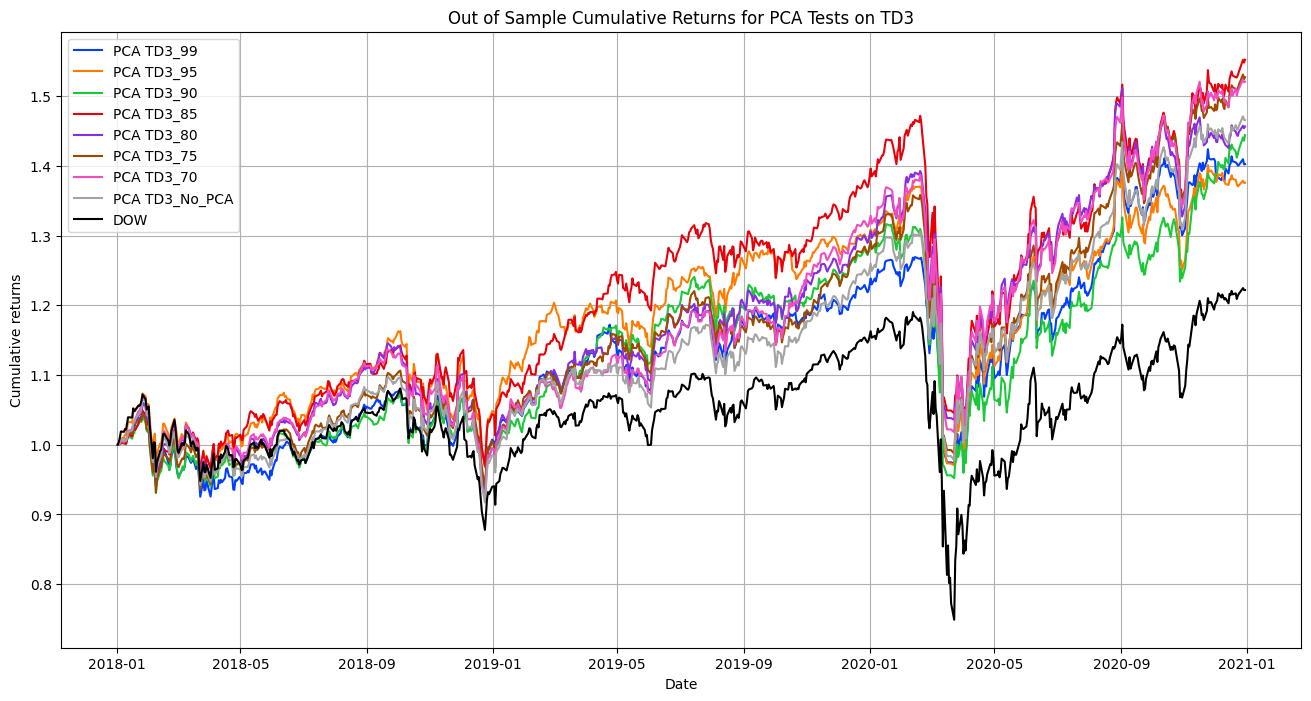

In [24]:
account_values = {}
for i in range(len(TD3_model_names)):
    account_values[TD3_model_names[i]] = results_dict_outSample[list(results_dict_outSample)[outSample_best_indexs[i]]]
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
plt.title("Out of Sample Cumulative Returns for PCA Tests on TD3")
plot_cumulative_returns(account_values, TD3_model_names)
plt.show()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2012, 8)


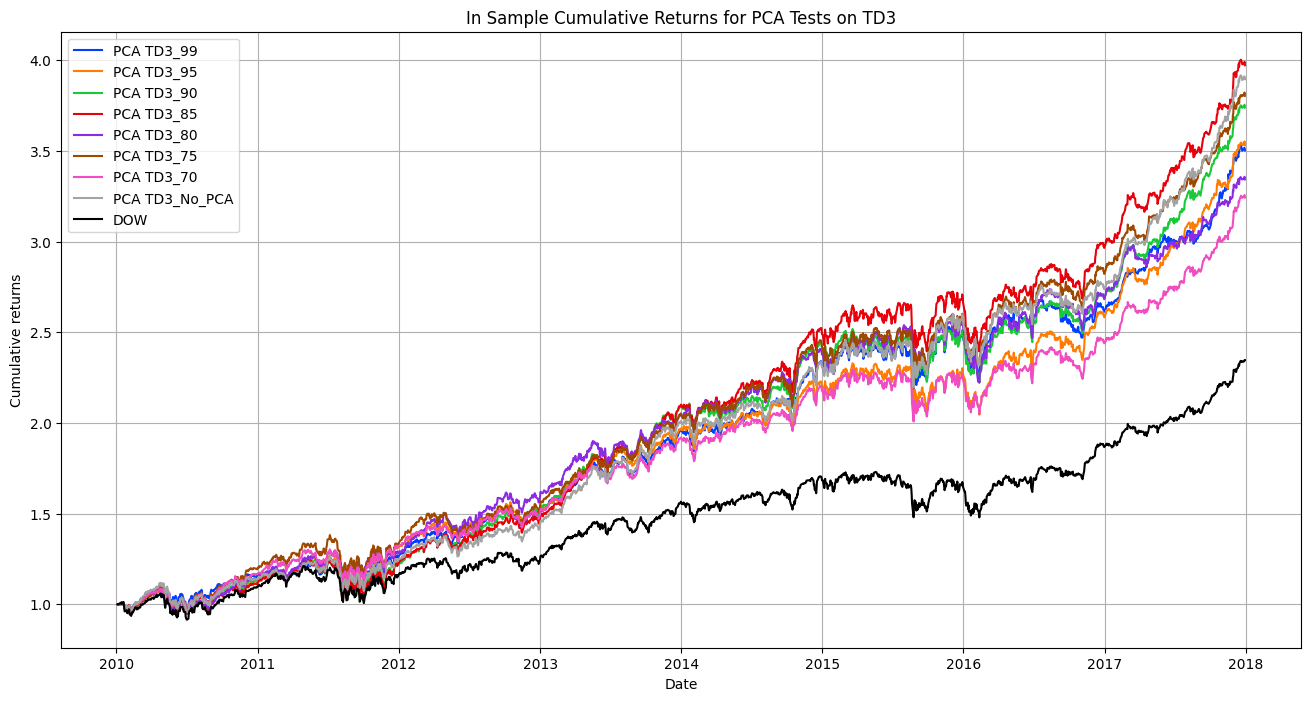

In [25]:
account_values = {}
for i in range(len(TD3_model_names)):
    account_values[TD3_model_names[i]] = results_dict_inSample[list(results_dict_inSample)[inSample_best_indexs[i]]]
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
plt.title("In Sample Cumulative Returns for PCA Tests on TD3")
plot_cumulative_returns(account_values, TD3_model_names)
plt.show()

# Test 2

## Environment

In [5]:
test_months = ["01", "04", "07", "10"]

In [6]:
def create_env(data):

    train = data.iloc[:0,:].copy()
    trade = data.iloc[:0,:].copy()
    mixed = data_split(data, TRAIN_START_DATE, TRAIN_END_DATE)
    
    for index, row in data.iterrows():
        if row["date"][5:-3] in test_months:
            trade = trade.append(row)
        else:
            train = train.append(row)

    trade = trade.sort_values(["date", "tic"], ignore_index=True)
    trade.index = trade["date"].factorize()[0]

    train = train.sort_values(["date", "tic"], ignore_index=True)
    train.index = train["date"].factorize()[0]

    stock_dimension = len(train.tic.unique())
    state_space = 1 + 2 * stock_dimension + len(data.columns[9:-2]) * stock_dimension

    num_stock_shares = [0] * stock_dimension
    buy_cost_list = sell_cost_list = [0.001] * stock_dimension

    env_kwargs1 = {
        'hmax': 100,
        "initial_amount": 1000000,
        "num_stock_shares": num_stock_shares,
        "buy_cost_pct": buy_cost_list,
        "sell_cost_pct": sell_cost_list,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": data.columns[9:-2],
        "action_space": stock_dimension,
        "reward_scaling": 1e-4
    }

    e_train_gym = StockTradingEnv(df = train, **env_kwargs1)
    e_trade_gym_out_of_sample = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs1)
    e_trade_gym_mixed = StockTradingEnv(df = mixed, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs1)
    
    training_env, _ = e_train_gym.get_sb_env()

    return training_env, e_trade_gym_out_of_sample, e_trade_gym_mixed

### PCA 99

In [7]:
Data99 = pd.read_csv("../Datasets/PCA/Dow_Pca_0.99.csv")
train_env_99, e_trade_env_99_outSample, e_trade_env_99_mixed  = create_env(Data99)

### PCA 95

In [8]:
Data95 = pd.read_csv("../Datasets/PCA/Dow_Pca_0.95.csv")
train_env_95, e_trade_env_95_outSample, e_trade_env_95_mixed = create_env(Data95)

### PCA 90

In [9]:
Data90 = pd.read_csv("../Datasets/PCA/Dow_Pca_0.9.csv")
train_env_90, e_trade_env_90_outSample, e_trade_env_90_mixed = create_env(Data90)

### PCA 85

In [10]:
Data85 = pd.read_csv("../Datasets/PCA/Dow_Pca_0.85.csv")
train_env_85, e_trade_env_85_outSample, e_trade_env_85_mixed = create_env(Data85)

### PCA 80

In [11]:
Data80 = pd.read_csv("../Datasets/PCA/Dow_Pca_0.8.csv")
train_env_80, e_trade_env_80_outSample, e_trade_env_80_mixed = create_env(Data80)

### PCA 75

In [12]:
Data75 = pd.read_csv("../Datasets/PCA/Dow_Pca_0.75.csv")
train_env_75, e_trade_env_75_outSample, e_trade_env_75_mixed = create_env(Data75)

### PCA 70

In [13]:
Data70 = pd.read_csv("../Datasets/PCA/Dow_Pca_0.7.csv")
train_env_70, e_trade_env_70_outSample, e_trade_env_70_mixed = create_env(Data70)

### No PCA

In [14]:
DataNoPCA = pd.read_csv("../Datasets/DOWIndicatorData.csv")
train_env, e_trade_env_outSample, e_trade_env_mixed = create_env(DataNoPCA)

## Training

In [15]:
def logger(alg, model):
    # set up logger
    tmp_path =  "PCA_test_models/tensorboard_log/" + alg
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model.set_logger(new_logger)
    return model

In [16]:
def save_model(trained, alg):
    trained.save("PCA_test_models/trained_models/" + alg)

### A2C

#### A2C 0.99

In [53]:
for i in range(5):
    agent = DRLAgent(env = train_env_99)
    A2C99_model = agent.get_model("a2c")
    A2C99_model = logger("A2C_99", A2C99_model)
    trained_A2C99 = agent.train_model(model=A2C99_model, tb_log_name='A2C_99', total_timesteps=10000)
    save_model(trained_A2C99, f"A2C_Staggered_Sampling/A2C_99/iter_{i+1}")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to PCA_test_models/tensorboard_log/A2C_99
-------------------------------------
| time/                 |           |
|    fps                | 87        |
|    iterations         | 100       |
|    time_elapsed       | 5         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | -1.07     |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 59.3      |
|    reward             | 1.5884966 |
|    std                | 1         |
|    value_loss         | 2.58      |
-------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 90          |
|    iterations         | 200         |
|    time_elapsed       | 11          |
|    total_timesteps    | 1000        |
| train/                |  

#### A2C 0.95

In [15]:
for i in range(5):
    agent = DRLAgent(env = train_env_95)
    A2C95_model = agent.get_model("a2c")
    A2C95_model = logger("A2C_95", A2C95_model)
    trained_A2C95 = agent.train_model(model=A2C95_model, tb_log_name='A2C_95', total_timesteps=10000)
    save_model(trained_A2C95, f"A2C_Staggered_Sampling/A2C_95/iter_{i+1}")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to PCA_test_models/tensorboard_log/A2C_95
-------------------------------------
| time/                 |           |
|    fps                | 92        |
|    iterations         | 100       |
|    time_elapsed       | 5         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | -0.18     |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 104       |
|    reward             | 1.8058134 |
|    std                | 1         |
|    value_loss         | 6.31      |
-------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 99          |
|    iterations         | 200         |
|    time_elapsed       | 10          |
|    total_timesteps    | 1000        |
| train/                |  

#### A2C 0.90

In [20]:
for i in range(5):
    agent = DRLAgent(env = train_env_90)
    A2C90_model = agent.get_model("a2c")
    A2C90_model = logger("A2C_90", A2C90_model)
    trained_A2C90 = agent.train_model(model=A2C90_model, tb_log_name='A2C_90', total_timesteps=10000)
    save_model(trained_A2C90, f"A2C_Staggered_Sampling/A2C_90/iter_{i+1}")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to PCA_test_models/tensorboard_log/A2C_90
-------------------------------------
| time/                 |           |
|    fps                | 107       |
|    iterations         | 100       |
|    time_elapsed       | 4         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 85.9      |
|    reward             | 0.6909691 |
|    std                | 1.01      |
|    value_loss         | 5.39      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 103        |
|    iterations         | 200        |
|    time_elapsed       | 9          |
|    total_timesteps    | 1000       |
| train/                |        

#### A2C 0.85

In [21]:
for i in range(5):
    agent = DRLAgent(env = train_env_85)
    A2C85_model = agent.get_model("a2c")
    A2C85_model = logger("A2C_85", A2C85_model)
    trained_A2C85 = agent.train_model(model=A2C85_model, tb_log_name='A2C_85', total_timesteps=10000)
    save_model(trained_A2C85, f"A2C_Staggered_Sampling/A2C_85/iter_{i+1}")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to PCA_test_models/tensorboard_log/A2C_85
-------------------------------------
| time/                 |           |
|    fps                | 146       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | -0.0122   |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 52.6      |
|    reward             | 1.3208978 |
|    std                | 1         |
|    value_loss         | 2.17      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 145       |
|    iterations         | 200       |
|    time_elapsed       | 6         |
|    total_timesteps    | 1000      |
| train/                |           |
|

#### A2C 0.80

In [28]:
for i in range(5):
    agent = DRLAgent(env = train_env_80)
    A2C80_model = agent.get_model("a2c")
    A2C80_model = logger("A2C_80", A2C80_model)
    trained_A2C80 = agent.train_model(model=A2C80_model, tb_log_name='A2C_80', total_timesteps=10000)
    save_model(trained_A2C80, f"A2C_Staggered_Sampling/A2C_80/iter_{i+1}")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to PCA_test_models/tensorboard_log/A2C_80
-------------------------------------
| time/                 |           |
|    fps                | 138       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41       |
|    explained_variance | -0.131    |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 54.1      |
|    reward             | 1.6754677 |
|    std                | 0.995     |
|    value_loss         | 1.98      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 136        |
|    iterations         | 200        |
|    time_elapsed       | 7          |
|    total_timesteps    | 1000       |
| train/                |        

#### A2C 0.75

In [29]:
for i in range(5):
    agent = DRLAgent(env = train_env_75)
    A2C75_model = agent.get_model("a2c")
    A2C75_model = logger("A2C_75", A2C75_model)
    trained_A2C75 = agent.train_model(model=A2C75_model, tb_log_name='A2C_75', total_timesteps=10000)
    save_model(trained_A2C75, f"A2C_Staggered_Sampling/A2C_75/iter_{i+1}")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to PCA_test_models/tensorboard_log/A2C_75
-------------------------------------
| time/                 |           |
|    fps                | 148       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | -0.0461   |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 70.6      |
|    reward             | 1.8836931 |
|    std                | 1.01      |
|    value_loss         | 4.55      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 150       |
|    iterations         | 200       |
|    time_elapsed       | 6         |
|    total_timesteps    | 1000      |
| train/                |           |
|

#### A2C 0.70

In [36]:
for i in range(5):    
    agent = DRLAgent(env = train_env_70)
    A2C70_model = agent.get_model("a2c")
    A2C70_model = logger("A2C_70", A2C70_model)
    trained_A2C70 = agent.train_model(model=A2C70_model, tb_log_name='A2C_70', total_timesteps=10000)
    save_model(trained_A2C70, f"A2C_Staggered_Sampling/A2C_70/iter_{i+1}")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to PCA_test_models/tensorboard_log/A2C_70
------------------------------------
| time/                 |          |
|    fps                | 128      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -41.2    |
|    explained_variance | -0.0226  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 84       |
|    reward             | 1.648475 |
|    std                | 1        |
|    value_loss         | 5.58     |
------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 135        |
|    iterations         | 200        |
|    time_elapsed       | 7          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entro

#### A2C No PCA

In [37]:
for i in range(5):    
    agent = DRLAgent(env = train_env)
    A2C_No_PCA_model = agent.get_model("a2c")
    A2C_No_PCA_model = logger("A2C_No_PCA", A2C_No_PCA_model)
    trained_A2C_No_PCA = agent.train_model(model=A2C_No_PCA_model, tb_log_name='A2C_No_PCA', total_timesteps=10000)
    save_model(trained_A2C_No_PCA, f"A2C_Staggered_Sampling/A2C_No_PCA/iter_{i+1}")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to PCA_test_models/tensorboard_log/A2C_No_PCA
--------------------------------------
| time/                 |            |
|    fps                | 100        |
|    iterations         | 100        |
|    time_elapsed       | 4          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0.135      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | 36         |
|    reward             | 0.90495706 |
|    std                | 1          |
|    value_loss         | 0.983      |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 101         |
|    iterations         | 200         |
|    time_elapsed       | 9           |
|    total_timesteps    | 1000        |
| train

### PPO

#### PPO 0.99

In [54]:
for i in range(5):   
    agent = DRLAgent(env = train_env_99)
    PPO99_model = agent.get_model("ppo")
    PPO99_model = logger("PPO_99", PPO99_model)
    trained_PPO99 = agent.train_model(model=PPO99_model, tb_log_name='PPO_99', total_timesteps=10000)
    save_model(trained_PPO99, f"PPO_Staggered_Sampling/PPO_99/iter_{i+1}")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to PCA_test_models/tensorboard_log/PPO_99
---------------------------------
| time/              |          |
|    fps             | 101      |
|    iterations      | 1        |
|    time_elapsed    | 20       |
|    total_timesteps | 2048     |
| train/             |          |
|    reward          | 0.695475 |
---------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 2           |
|    time_elapsed         | 43          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018548083 |
|    clip_fraction        | 0.281       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0197     |
|    learning_rate        | 0.00025     |
|

#### PPO 0.95

In [16]:
for i in range(5): 
    agent = DRLAgent(env = train_env_95)
    PPO95_model = agent.get_model("ppo")
    PPO95_model = logger("PPO_95", PPO95_model)
    trained_PPO95 = agent.train_model(model=PPO95_model, tb_log_name='PPO_95', total_timesteps=10000)
    save_model(trained_PPO95, f"PPO_Staggered_Sampling/PPO_95/iter_{i+1}")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to PCA_test_models/tensorboard_log/PPO_95
----------------------------------
| time/              |           |
|    fps             | 133       |
|    iterations      | 1         |
|    time_elapsed    | 15        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.5622459 |
----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 122        |
|    iterations           | 2          |
|    time_elapsed         | 33         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01459956 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -41.2      |
|    explained_variance   | -0.000598  |
|    learning_rate        | 0.00025    |
|    

#### PPO 0.90

In [22]:
for i in range(5): 
    agent = DRLAgent(env = train_env_90)
    PPO90_model = agent.get_model("ppo")
    PPO90_model = logger("PPO_90", PPO90_model)
    trained_PPO90 = agent.train_model(model=PPO90_model, tb_log_name='PPO_90', total_timesteps=10000)
    save_model(trained_PPO90, f"PPO_Staggered_Sampling/PPO_90/iter_{i+1}")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to PCA_test_models/tensorboard_log/PPO_90
----------------------------------
| time/              |           |
|    fps             | 169       |
|    iterations      | 1         |
|    time_elapsed    | 12        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.5499698 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 2           |
|    time_elapsed         | 25          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020512775 |
|    clip_fraction        | 0.268       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.00487     |
|    learning_rate        | 0.0002

#### PPO 0.85

In [23]:
for i in range(5): 
    agent = DRLAgent(env = train_env_85)
    PPO85_model = agent.get_model("ppo")
    PPO85_model = logger("PPO_85", PPO85_model)
    trained_PPO85 = agent.train_model(model=PPO85_model, tb_log_name='PPO_85', total_timesteps=10000)
    save_model(trained_PPO85, f"PPO_Staggered_Sampling/PPO_85/iter_{i+1}")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to PCA_test_models/tensorboard_log/PPO_85
-----------------------------------
| time/              |            |
|    fps             | 171        |
|    iterations      | 1          |
|    time_elapsed    | 11         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.62385845 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 2           |
|    time_elapsed         | 25          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019823847 |
|    clip_fraction        | 0.259       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.029      |
|    learning_rate       

#### PPO 0.80

In [30]:
for i in range(5):     
    agent = DRLAgent(env = train_env_80)
    PPO80_model = agent.get_model("ppo")
    PPO80_model = logger("PPO_80", PPO80_model)
    trained_PPO80 = agent.train_model(model=PPO80_model, tb_log_name='PPO_80', total_timesteps=10000)
    save_model(trained_PPO80, f"PPO_Staggered_Sampling/PPO_80/iter_{i+1}")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to PCA_test_models/tensorboard_log/PPO_80
-----------------------------------
| time/              |            |
|    fps             | 168        |
|    iterations      | 1          |
|    time_elapsed    | 12         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.70571744 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 2           |
|    time_elapsed         | 25          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016570546 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.00553    |
|    learning_rate       

#### PPO 0.75

In [31]:
for i in range(5): 
    agent = DRLAgent(env = train_env_75)
    PPO75_model = agent.get_model("ppo")
    PPO75_model = logger("PPO_75", PPO75_model)
    trained_PPO75 = agent.train_model(model=PPO75_model, tb_log_name='PPO_75', total_timesteps=10000)
    save_model(trained_PPO75, f"PPO_Staggered_Sampling/PPO_75/iter_{i+1}")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to PCA_test_models/tensorboard_log/PPO_75
-----------------------------------
| time/              |            |
|    fps             | 169        |
|    iterations      | 1          |
|    time_elapsed    | 12         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.85057616 |
-----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 2          |
|    time_elapsed         | 25         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01972583 |
|    clip_fraction        | 0.269      |
|    clip_range           | 0.2        |
|    entropy_loss         | -41.2      |
|    explained_variance   | 0.00782    |
|    learning_rate        | 0.00025  

#### PPO 0.70

In [38]:
for i in range(5): 
    agent = DRLAgent(env = train_env_70)
    PPO70_model = agent.get_model("ppo")
    PPO70_model = logger("PPO_70", PPO70_model)
    trained_PPO70 = agent.train_model(model=PPO70_model, tb_log_name='PPO_70', total_timesteps=10000)
    save_model(trained_PPO70, f"PPO_Staggered_Sampling/PPO_70/iter_{i+1}")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to PCA_test_models/tensorboard_log/PPO_70
-----------------------------------
| time/              |            |
|    fps             | 42         |
|    iterations      | 1          |
|    time_elapsed    | 48         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.53968036 |
-----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 62         |
|    iterations           | 2          |
|    time_elapsed         | 65         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.02234149 |
|    clip_fraction        | 0.268      |
|    clip_range           | 0.2        |
|    entropy_loss         | -41.2      |
|    explained_variance   | -0.011     |
|    learning_rate        | 0.00025  

#### PPO No PCA

In [17]:
for i in range(5): 
    agent = DRLAgent(env = train_env)
    PPO_No_PCA_model = agent.get_model("ppo")
    PPO_No_PCA_model = logger("PPO_No_PCA", PPO_No_PCA_model)
    trained_PPO_No_PCA = agent.train_model(model=PPO_No_PCA_model, tb_log_name='PPO_No_PCA', total_timesteps=10000)
    save_model(trained_PPO_No_PCA, f"PPO_Staggered_Sampling/PPO_No_PCA/iter_{i+1}")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to PCA_test_models/tensorboard_log/PPO_No_PCA
----------------------------------
| time/              |           |
|    fps             | 100       |
|    iterations      | 1         |
|    time_elapsed    | 20        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.7266988 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 2           |
|    time_elapsed         | 42          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017920092 |
|    clip_fraction        | 0.271       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0131     |
|    learning_rate        | 0.

### TD3

#### TD3 0.99

In [55]:
for i in range(5):   
    agent = DRLAgent(env = train_env_99)
    TD399_model = agent.get_model("td3")
    TD399_model = logger("TD3_99", TD399_model)
    trained_TD399 = agent.train_model(model=TD399_model, tb_log_name='TD3_99', total_timesteps=10000)
    save_model(trained_TD399, f"TD3_Staggered_Sampling/TD3_99/iter_{i+1}")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_99
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 24        |
|    time_elapsed    | 301       |
|    total_timesteps | 7368      |
| train/             |           |
|    actor_loss      | 131       |
|    critic_loss     | 1.34e+04  |
|    learning_rate   | 0.001     |
|    n_updates       | 5526      |
|    reward          | 1.8555144 |
----------------------------------
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_99
day: 1841, episode: 70
begin_total_asset: 1000000.00
end_total_asset: 3544878.60
total_reward: 2544878.60
total_cost: 1224.15
total_trades: 33145
Sharpe: 0.888
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps  

#### TD3 0.95

In [17]:
for i in range(5):   
    agent = DRLAgent(env = train_env_95)
    TD395_model = agent.get_model("td3")
    TD395_model = logger("TD3_95", TD395_model)
    trained_TD395 = agent.train_model(model=TD395_model, tb_log_name='TD3_95', total_timesteps=10000)
    save_model(trained_TD395, f"TD3_Staggered_Sampling/TD3_95/iter_{i+1}")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_95
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 52         |
|    time_elapsed    | 140        |
|    total_timesteps | 7368       |
| train/             |            |
|    actor_loss      | 12.9       |
|    critic_loss     | 661        |
|    learning_rate   | 0.001      |
|    n_updates       | 5526       |
|    reward          | 0.52360505 |
-----------------------------------
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_95
day: 1841, episode: 70
begin_total_asset: 1000000.00
end_total_asset: 3150186.37
total_reward: 2150186.37
total_cost: 1079.02
total_trades: 23969
Sharpe: 0.825
-----------------------------------
| time/              |            |
|    episodes        | 4      

#### TD3 0.90

In [24]:
for i in range(5):   
    agent = DRLAgent(env = train_env_90)
    TD390_model = agent.get_model("td3")
    TD390_model = logger("TD3_90", TD390_model)
    trained_TD390 = agent.train_model(model=TD390_model, tb_log_name='TD3_90', total_timesteps=10000)
    save_model(trained_TD390, f"TD3_Staggered_Sampling/TD3_90/iter_{i+1}")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_90
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 52       |
|    time_elapsed    | 140      |
|    total_timesteps | 7368     |
| train/             |          |
|    actor_loss      | 9.99     |
|    critic_loss     | 449      |
|    learning_rate   | 0.001    |
|    n_updates       | 5526     |
|    reward          | 2.049762 |
---------------------------------
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_90
day: 1841, episode: 70
begin_total_asset: 1000000.00
end_total_asset: 3366249.15
total_reward: 2366249.15
total_cost: 999.00
total_trades: 31271
Sharpe: 0.824
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             

#### TD3 0.85

In [25]:
for i in range(5):   
    agent = DRLAgent(env = train_env_85)
    TD385_model = agent.get_model("td3")
    TD385_model = logger("TD3_85", TD385_model)
    trained_TD385 = agent.train_model(model=TD385_model, tb_log_name='TD3_85', total_timesteps=10000)
    save_model(trained_TD385, f"TD3_Staggered_Sampling/TD3_85/iter_{i+1}")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_85
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 53        |
|    time_elapsed    | 138       |
|    total_timesteps | 7368      |
| train/             |           |
|    actor_loss      | -51       |
|    critic_loss     | 4.01e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 5526      |
|    reward          | 1.4206728 |
----------------------------------
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_85
day: 1841, episode: 70
begin_total_asset: 1000000.00
end_total_asset: 3665992.11
total_reward: 2665992.11
total_cost: 998.99
total_trades: 23933
Sharpe: 0.855
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps   

#### TD3 0.80

In [32]:
for i in range(5):   
    agent = DRLAgent(env = train_env_80)
    TD380_model = agent.get_model("td3")
    TD380_model = logger("TD3_80", TD380_model)
    trained_TD380 = agent.train_model(model=TD380_model, tb_log_name='TD3_80', total_timesteps=10000)
    save_model(trained_TD380, f"TD3_Staggered_Sampling/TD3_80/iter_{i+1}")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_80
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 52       |
|    time_elapsed    | 139      |
|    total_timesteps | 7368     |
| train/             |          |
|    actor_loss      | 96.9     |
|    critic_loss     | 4.37e+03 |
|    learning_rate   | 0.001    |
|    n_updates       | 5526     |
|    reward          | 0.938293 |
---------------------------------
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_80
day: 1841, episode: 70
begin_total_asset: 1000000.00
end_total_asset: 3500873.38
total_reward: 2500873.38
total_cost: 1257.30
total_trades: 35025
Sharpe: 0.885
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps            

#### TD3 0.75

In [33]:
for i in range(5):   
    agent = DRLAgent(env = train_env_75)
    TD375_model = agent.get_model("td3")
    TD375_model = logger("TD3_75", TD375_model)
    trained_TD375 = agent.train_model(model=TD375_model, tb_log_name='TD3_75', total_timesteps=10000)
    save_model(trained_TD375, f"TD3_Staggered_Sampling/TD3_75/iter_{i+1}")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_75
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 52         |
|    time_elapsed    | 139        |
|    total_timesteps | 7368       |
| train/             |            |
|    actor_loss      | 64.2       |
|    critic_loss     | 2.76e+03   |
|    learning_rate   | 0.001      |
|    n_updates       | 5526       |
|    reward          | 0.52000445 |
-----------------------------------
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_75
day: 1841, episode: 70
begin_total_asset: 1000000.00
end_total_asset: 4775264.82
total_reward: 3775264.82
total_cost: 1341.65
total_trades: 23978
Sharpe: 1.094
-----------------------------------
| time/              |            |
|    episodes        | 4      

#### TD3 0.70

In [40]:
for i in range(5):   
    agent = DRLAgent(env = train_env_70)
    TD370_model = agent.get_model("td3")
    TD370_model = logger("TD3_70", TD370_model)
    trained_TD370 = agent.train_model(model=TD370_model, tb_log_name='TD3_70', total_timesteps=10000)
    save_model(trained_TD370, f"TD3_Staggered_Sampling/TD3_70/iter_{i+1}")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_70
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 48         |
|    time_elapsed    | 151        |
|    total_timesteps | 7368       |
| train/             |            |
|    actor_loss      | 118        |
|    critic_loss     | 4.58e+03   |
|    learning_rate   | 0.001      |
|    n_updates       | 5526       |
|    reward          | 0.88014287 |
-----------------------------------
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_70
day: 1841, episode: 70
begin_total_asset: 1000000.00
end_total_asset: 3366261.67
total_reward: 2366261.67
total_cost: 999.00
total_trades: 24314
Sharpe: 0.835
-----------------------------------
| time/              |            |
|    episodes        | 4       

#### TD3 No PCA

In [18]:
for i in range(5):   
    agent = DRLAgent(env = train_env)
    TD3_No_PCA_model = agent.get_model("td3")
    TD3_No_PCA_model = logger("TD3_No_PCA", TD3_No_PCA_model)
    trained_TD3_No_PCA = agent.train_model(model=TD3_No_PCA_model, tb_log_name='TD3_No_PCA', total_timesteps=10000)
    save_model(trained_TD3_No_PCA, f"TD3_Staggered_Sampling/TD3_No_PCA/iter_{i+1}")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_No_PCA
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 39        |
|    time_elapsed    | 187       |
|    total_timesteps | 7368      |
| train/             |           |
|    actor_loss      | 92.4      |
|    critic_loss     | 1.94e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 5526      |
|    reward          | 0.7785763 |
----------------------------------
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to PCA_test_models/tensorboard_log/TD3_No_PCA
day: 1841, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 4250696.67
total_reward: 3250696.67
total_cost: 998.99
total_trades: 14728
Sharpe: 0.964
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    f

## Evaluation

In [15]:
import empyrical as ep
import seaborn as sns
from copy import deepcopy
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

def plot_cumulative_returns_staggered(account_values, alg_names):
    colors = sns.color_palette("bright")
    counter = 0
    unique_days = Data99['date'].unique()

    for i in account_values:
        dates = account_values[i]["date"].unique()
        df = deepcopy(account_values[i])


        df["date"] = pd.to_datetime(df["date"], format="%Y/%m/%d")
        bt_returns = get_daily_return(df, value_col_name="account_value")
        cum_rets = ep.cum_returns(bt_returns, 1.0)
        cum_rets = cum_rets.tz_localize(None)
    

        for j in unique_days:
            if j not in dates:
                cum_rets = cum_rets.append(pd.Series([np.nan], index = [pd.to_datetime(j, format="%Y/%m/%d")]))
        cum_rets = cum_rets.sort_index()
        
        # print(cum_rets)
    
        plt.plot(cum_rets.index, cum_rets.values, color = colors[counter], label = f"PCA {alg_names[counter]}")
        counter += 1
    
    # default_x_ticks = range(len(dates))
    # plt.xticks(default_x_ticks, dates)
    

    DJI_value = YahooDownloader(
        start_date=unique_days[0],
        end_date=unique_days[-1],
        ticker_list=['^DJI']
    ).fetch_data()
    DJI_value["date"] = pd.to_datetime(DJI_value["date"], format="%Y-%m-%d")
    # DJI_value = pd.merge(df[["date"]], DJI_value, how="left", on="date")
    # DJI_value = DJI_value.fillna(method="ffill").fillna(method="bfill")
    benchmark_rets = get_daily_return(DJI_value, value_col_name="close")
    benchmark_rets.name = "DJI"


    cum_factor_returns = ep.cum_returns(benchmark_rets, 1.0)
    # print(benchmark_rets)
    # print(cum_factor_returns)
    plt.plot(cum_factor_returns.index, cum_factor_returns.values, label = "DOW", color = 'black')
    
    plt.grid()
    plt.ylabel('Cumulative returns')
    plt.xlabel('Date')
    plt.legend()
    plt.show()

In [16]:
out_of_sample_envs = [e_trade_env_99_outSample, e_trade_env_95_outSample, e_trade_env_90_outSample, e_trade_env_85_outSample, e_trade_env_80_outSample, e_trade_env_75_outSample, e_trade_env_70_outSample, e_trade_env_outSample]
mixed_envs = [e_trade_env_99_mixed, e_trade_env_95_mixed, e_trade_env_90_mixed, e_trade_env_85_mixed, e_trade_env_80_mixed, e_trade_env_75_mixed, e_trade_env_70_mixed, e_trade_env_mixed]

### A2C

In [22]:
A2C_model_names = ["A2C_99", "A2C_95", "A2C_90", "A2C_85", "A2C_80", "A2C_75", "A2C_70", "A2C_No_PCA"]
A2C_models = load_models(A2C_model_names, A2C, "A2C_Staggered_Sampling")

In [27]:
# Out of sample
with suppress_stdout():
    results_dict_outSample = group_sample_perf(A2C_models, A2C_model_names, out_of_sample_envs)

# mixed sample
with suppress_stdout():
    results_dict_mixed = group_sample_perf(A2C_models, A2C_model_names, mixed_envs)

In [28]:
print("Out Of Sample Results")
data, outSample_best_indexs = states(results_dict_outSample)
print(tabulate(data, A2C_model_names, tablefmt="outline"))

Out Of Sample Results
+---------------------+----------+----------+----------+----------+----------+----------+----------+--------------+
|                     |   A2C_99 |   A2C_95 |   A2C_90 |   A2C_85 |   A2C_80 |   A2C_75 |   A2C_70 |   A2C_No_PCA |
+=====================+==========+==========+==========+==========+==========+==========+==========+==============+
| Annual return       |   0.5965 |   0.5476 |   0.6078 |   0.6581 |   0.3464 |   0.4891 |   0.4973 |       0.5192 |
| Cumulative returns  |   4.5785 |   3.976  |   4.7257 |   5.4117 |   1.9827 |   3.3195 |   3.4078 |       3.6494 |
| Annual volatility   |   0.2813 |   0.2402 |   0.2937 |   0.258  |   0.2372 |   0.2334 |   0.2258 |       0.252  |
| Sharpe ratio        |   1.8086 |   1.9424 |   1.7698 |   2.0945 |   1.3766 |   1.8279 |   1.9048 |       1.7912 |
| Calmar ratio        |   2.3588 |   2.9893 |   2.1779 |   2.8183 |   1.6763 |   2.5317 |   3.0116 |       2.6305 |
| Stability           |   0.9845 |   0.9846 |   0.

In [29]:
print("Out Of Sample Results")
data2, mixed_best_indexs = states(results_dict_mixed)
print(tabulate(data, A2C_model_names, tablefmt="outline"))

Out Of Sample Results
+---------------------+----------+----------+----------+----------+----------+----------+----------+--------------+
|                     |   A2C_99 |   A2C_95 |   A2C_90 |   A2C_85 |   A2C_80 |   A2C_75 |   A2C_70 |   A2C_No_PCA |
+=====================+==========+==========+==========+==========+==========+==========+==========+==============+
| Annual return       |   0.5965 |   0.5476 |   0.6078 |   0.6581 |   0.3464 |   0.4891 |   0.4973 |       0.5192 |
| Cumulative returns  |   4.5785 |   3.976  |   4.7257 |   5.4117 |   1.9827 |   3.3195 |   3.4078 |       3.6494 |
| Annual volatility   |   0.2813 |   0.2402 |   0.2937 |   0.258  |   0.2372 |   0.2334 |   0.2258 |       0.252  |
| Sharpe ratio        |   1.8086 |   1.9424 |   1.7698 |   2.0945 |   1.3766 |   1.8279 |   1.9048 |       1.7912 |
| Calmar ratio        |   2.3588 |   2.9893 |   2.1779 |   2.8183 |   1.6763 |   2.5317 |   3.0116 |       2.6305 |
| Stability           |   0.9845 |   0.9846 |   0.

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2767, 8)


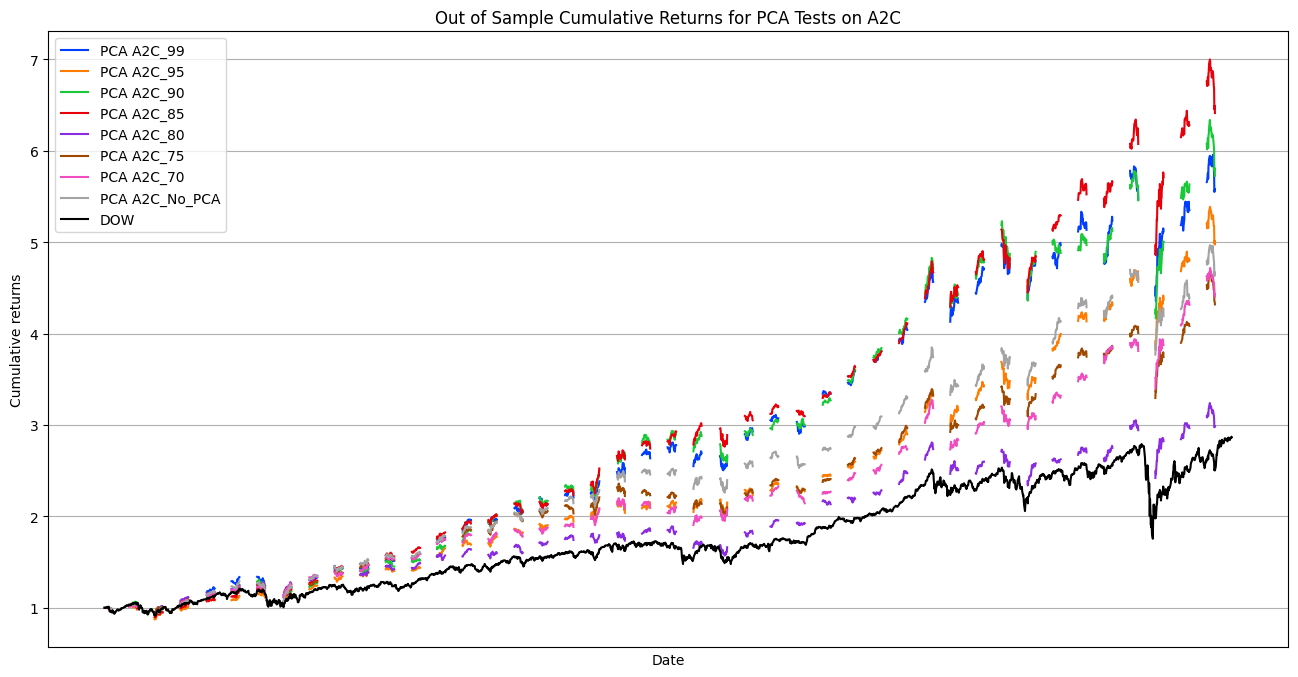

In [30]:
account_values = {}
for i in range(len(A2C_model_names)):
    account_values[A2C_model_names[i]] = results_dict_outSample[list(results_dict_outSample)[outSample_best_indexs[i]]]
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
plt.title("Out of Sample Cumulative Returns for PCA Tests on A2C")
plot_cumulative_returns_staggered(account_values, A2C_model_names)
plt.show()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2012, 8)


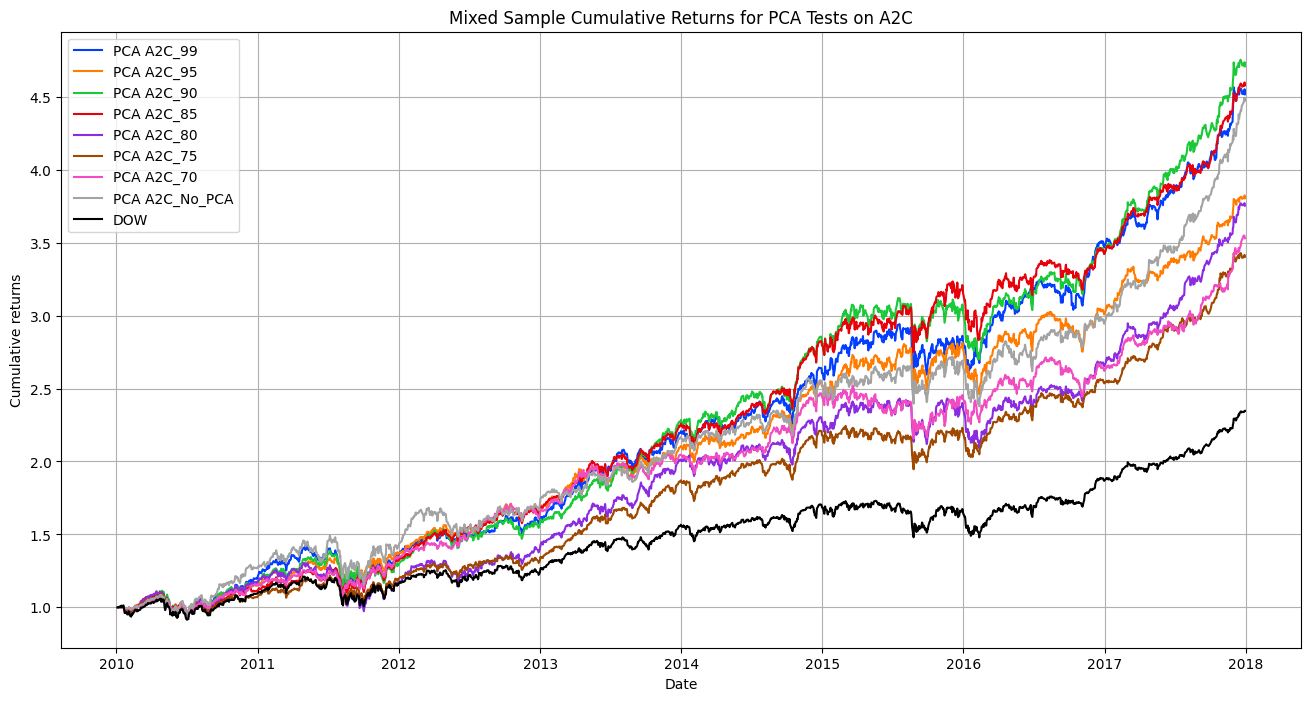

In [31]:
account_values = {}
for i in range(len(A2C_model_names)):
    account_values[A2C_model_names[i]] = results_dict_mixed[list(results_dict_mixed)[mixed_best_indexs[i]]]
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
plt.title("Mixed Sample Cumulative Returns for PCA Tests on A2C")
plot_cumulative_returns(account_values, A2C_model_names)
plt.show()

### PPO

In [27]:
PPO_model_names = ["PPO_99", "PPO_95", "PPO_90", "PPO_85", "PPO_80", "PPO_75", "PPO_70", "PPO_No_PCA"]
PPO_models = load_models(PPO_model_names, PPO, "PPO_Staggered_Sampling")

In [28]:
# Out of sample
with suppress_stdout():
    results_dict_outSample = group_sample_perf(PPO_models, PPO_model_names, out_of_sample_envs)

# Mixed sample
with suppress_stdout():
    results_dict_mixed = group_sample_perf(PPO_models, PPO_model_names, mixed_envs)

In [29]:
print("Out Of Sample Results")
data, outSample_best_indexs = states(results_dict_outSample)
print(tabulate(data, PPO_model_names, tablefmt="outline"))

Out Of Sample Results
+---------------------+----------+----------+----------+----------+----------+----------+----------+--------------+
|                     |   PPO_99 |   PPO_95 |   PPO_90 |   PPO_85 |   PPO_80 |   PPO_75 |   PPO_70 |   PPO_No_PCA |
+=====================+==========+==========+==========+==========+==========+==========+==========+==============+
| Annual return       |   0.4298 |   0.4039 |   0.4225 |   0.4187 |   0.4141 |   0.4154 |   0.4591 |       0.4371 |
| Cumulative returns  |   2.7205 |   2.4783 |   2.6509 |   2.6154 |   2.5722 |   2.5847 |   3.008  |       2.7902 |
| Annual volatility   |   0.2577 |   0.2068 |   0.2429 |   0.2434 |   0.2236 |   0.2468 |   0.2208 |       0.2123 |
| Sharpe ratio        |   1.5264 |   1.7483 |   1.5808 |   1.5671 |   1.6674 |   1.5375 |   1.8278 |       1.8186 |
| Calmar ratio        |   1.4031 |   1.9664 |   1.5122 |   1.5545 |   1.7022 |   1.5801 |   1.8779 |       2.3139 |
| Stability           |   0.9644 |   0.9548 |   0.

In [30]:
print("Mixed Sample Results")
data, mixed_best_indexs = states(results_dict_mixed)
print(tabulate(data, PPO_model_names, tablefmt="outline"))

Mixed Sample Results
+---------------------+----------+----------+----------+----------+----------+----------+----------+--------------+
|                     |   PPO_99 |   PPO_95 |   PPO_90 |   PPO_85 |   PPO_80 |   PPO_75 |   PPO_70 |   PPO_No_PCA |
+=====================+==========+==========+==========+==========+==========+==========+==========+==============+
| Annual return       |   0.194  |   0.1771 |   0.17   |   0.1649 |   0.1692 |   0.1855 |   0.1727 |       0.1622 |
| Cumulative returns  |   3.1216 |   2.6787 |   2.5042 |   2.3853 |   2.4857 |   2.8932 |   2.5698 |       2.3232 |
| Annual volatility   |   0.1345 |   0.147  |   0.1332 |   0.1212 |   0.1238 |   0.139  |   0.1343 |       0.115  |
| Sharpe ratio        |   1.3861 |   1.1841 |   1.2466 |   1.3211 |   1.3254 |   1.2949 |   1.2541 |       1.3655 |
| Calmar ratio        |   1.3144 |   0.9123 |   0.8426 |   1.0715 |   1.1205 |   1.1867 |   1.103  |       1.17   |
| Stability           |   0.9628 |   0.9693 |   0.9

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2767, 8)


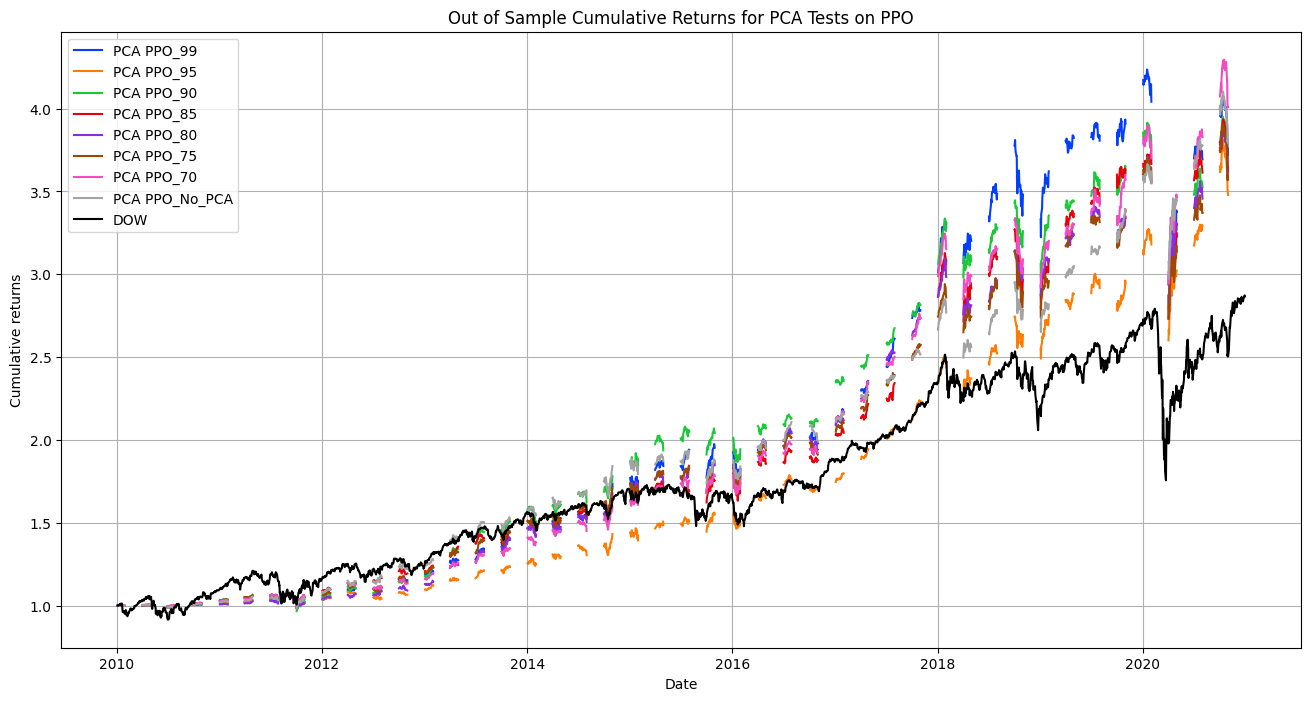

In [31]:
account_values = {}
for i in range(len(PPO_model_names)):
    account_values[PPO_model_names[i]] = results_dict_outSample[list(results_dict_outSample)[outSample_best_indexs[i]]]
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
plt.title("Out of Sample Cumulative Returns for PCA Tests on PPO")
plot_cumulative_returns_staggered(account_values, PPO_model_names)
plt.show()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2012, 8)


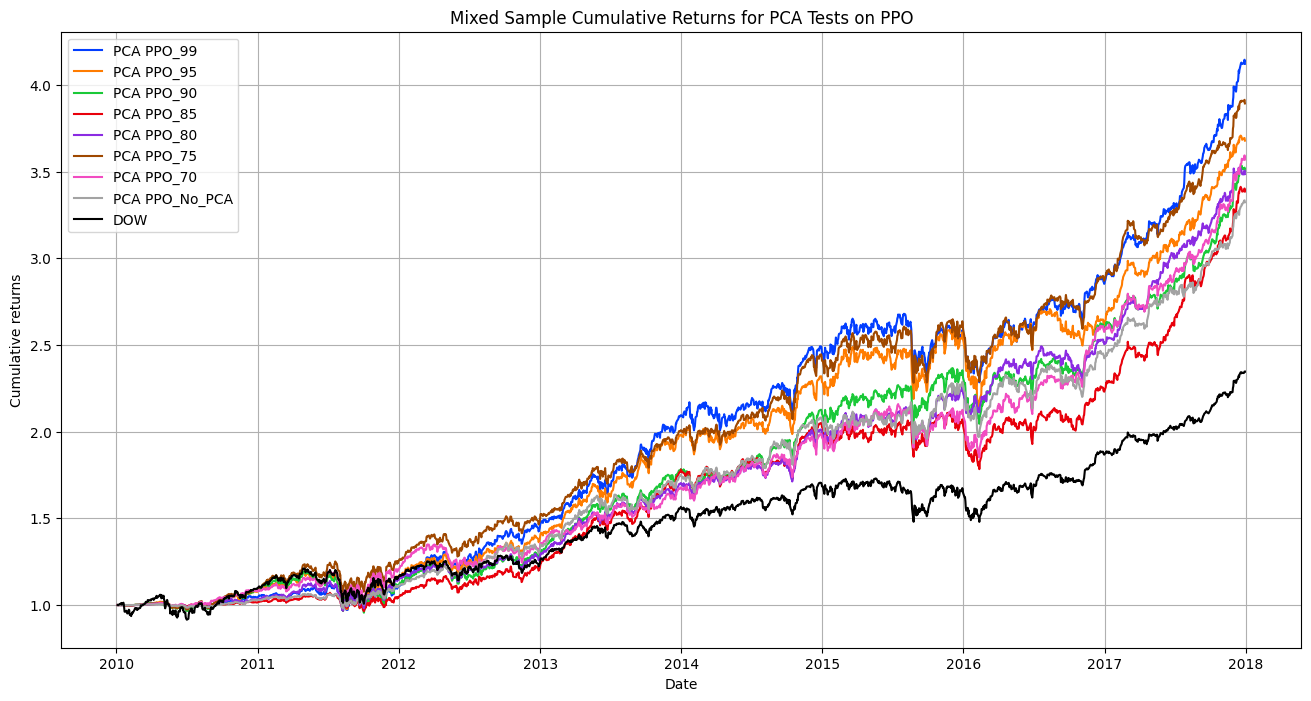

In [32]:
account_values = {}
for i in range(len(PPO_model_names)):
    account_values[PPO_model_names[i]] = results_dict_mixed[list(results_dict_mixed)[mixed_best_indexs[i]]]
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
plt.title("Mixed Sample Cumulative Returns for PCA Tests on PPO")
plot_cumulative_returns(account_values, PPO_model_names)
plt.show()

### TD3

In [23]:
TD3_model_names = ["TD3_99", "TD3_95", "TD3_90", "TD3_85", "TD3_80", "TD3_75", "TD3_70", "TD3_No_PCA"]
TD3_models = load_models(TD3_model_names, TD3, "TD3_Staggered_Sampling")

In [24]:
# Out of sample
with suppress_stdout():
    results_dict_outSample = group_sample_perf(TD3_models, TD3_model_names, out_of_sample_envs)

# Mixed sample
with suppress_stdout():
    results_dict_mixed = group_sample_perf(TD3_models, TD3_model_names, mixed_envs)

In [25]:
print("Out Of Sample Results")
data, outSample_best_indexs = states(results_dict_outSample)
print(tabulate(data, TD3_model_names, tablefmt="outline"))

Out Of Sample Results
+---------------------+----------+----------+----------+----------+----------+----------+----------+--------------+
|                     |   TD3_99 |   TD3_95 |   TD3_90 |   TD3_85 |   TD3_80 |   TD3_75 |   TD3_70 |   TD3_No_PCA |
+=====================+==========+==========+==========+==========+==========+==========+==========+==============+
| Annual return       |   0.5281 |   0.4545 |   0.5329 |   0.4841 |   0.4921 |   0.5204 |   0.4436 |       0.5131 |
| Cumulative returns  |   3.7497 |   2.9618 |   3.8045 |   3.2662 |   3.3515 |   3.6621 |   2.8543 |       3.5806 |
| Annual volatility   |   0.2364 |   0.2392 |   0.2639 |   0.2581 |   0.264  |   0.2575 |   0.2598 |       0.2703 |
| Sharpe ratio        |   1.9175 |   1.6916 |   1.7564 |   1.6666 |   1.6562 |   1.7604 |   1.5501 |       1.6753 |
| Calmar ratio        |   2.4889 |   2.0482 |   2.2665 |   1.8934 |   1.7673 |   2.4921 |   1.7508 |       1.9652 |
| Stability           |   0.9877 |   0.9767 |   0.

In [26]:
print("Mixed Sample Results")
data, mixed_best_indexs = states(results_dict_mixed)
print(tabulate(data, TD3_model_names, tablefmt="outline"))

Mixed Sample Results
+---------------------+----------+----------+----------+----------+----------+----------+----------+--------------+
|                     |   TD3_99 |   TD3_95 |   TD3_90 |   TD3_85 |   TD3_80 |   TD3_75 |   TD3_70 |   TD3_No_PCA |
+=====================+==========+==========+==========+==========+==========+==========+==========+==============+
| Annual return       |   0.1739 |   0.1552 |   0.183  |   0.1781 |   0.1759 |   0.1855 |   0.1612 |       0.1778 |
| Cumulative returns  |   2.5995 |   2.1657 |   2.8279 |   2.7042 |   2.6496 |   2.8928 |   2.3007 |       2.6961 |
| Annual volatility   |   0.126  |   0.1352 |   0.1458 |   0.1404 |   0.1352 |   0.1393 |   0.1357 |       0.1423 |
| Sharpe ratio        |   1.3361 |   1.1358 |   1.2264 |   1.2389 |   1.2673 |   1.2921 |   1.1701 |       1.222  |
| Calmar ratio        |   1.266  |   0.848  |   0.9814 |   1.146  |   1.1237 |   1.0953 |   1.0827 |       1.1249 |
| Stability           |   0.9812 |   0.9672 |   0.9

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2767, 8)


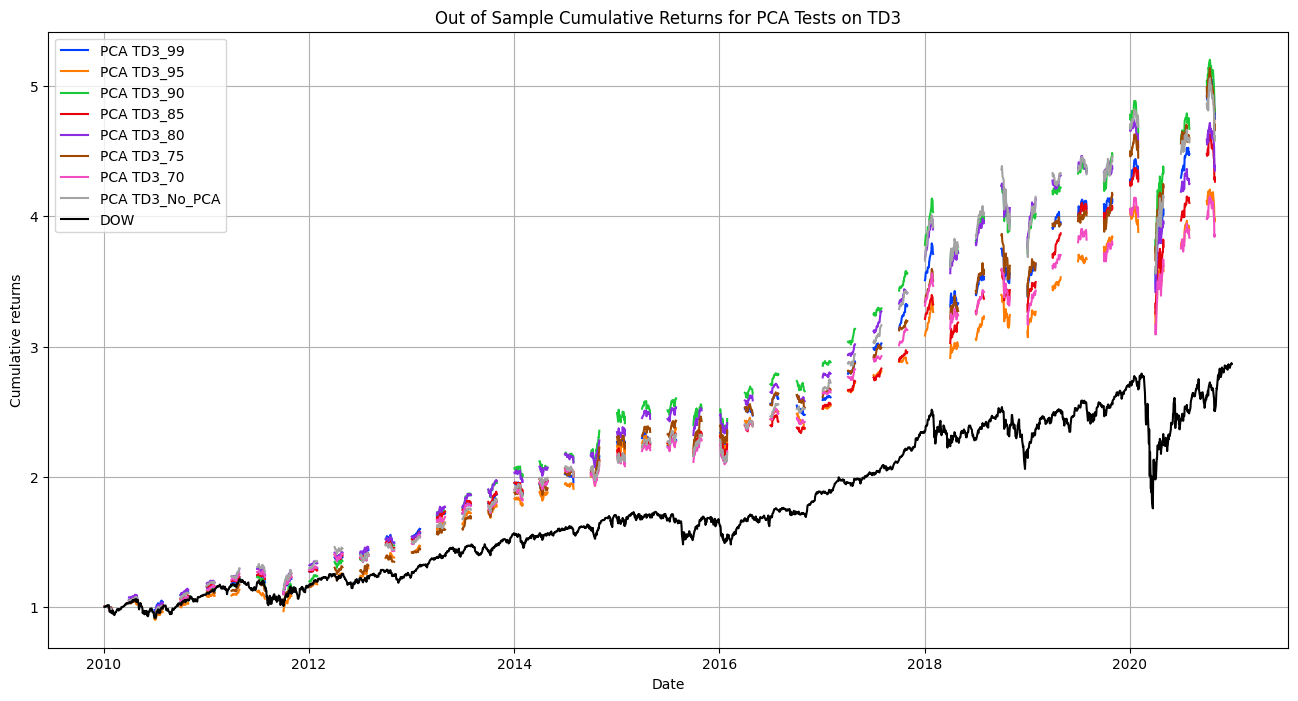

In [27]:
account_values = {}
for i in range(len(TD3_model_names)):
    account_values[TD3_model_names[i]] = results_dict_outSample[list(results_dict_outSample)[outSample_best_indexs[i]]]
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
plt.title("Out of Sample Cumulative Returns for PCA Tests on TD3")
plot_cumulative_returns_staggered(account_values, TD3_model_names)
plt.show()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2012, 8)


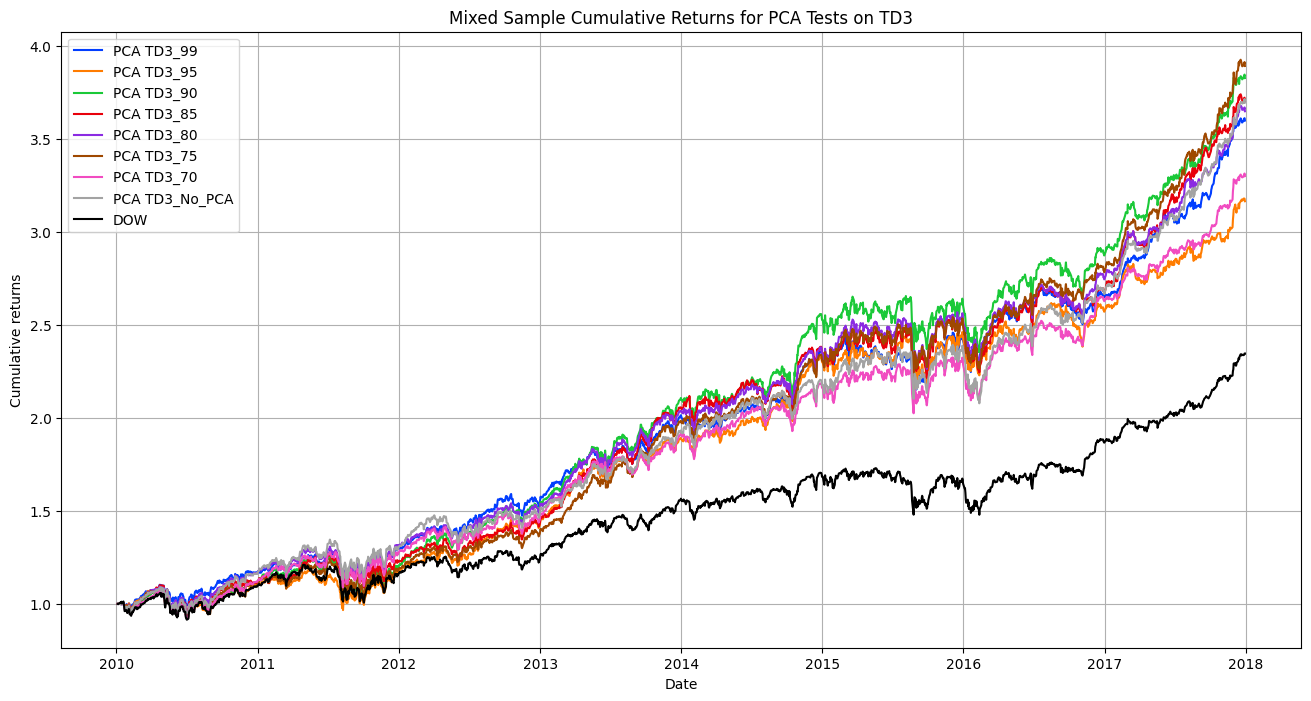

In [29]:
account_values = {}
for i in range(len(TD3_model_names)):
    account_values[TD3_model_names[i]] = results_dict_mixed[list(results_dict_mixed)[mixed_best_indexs[i]]]
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
plt.title("Mixed Sample Cumulative Returns for PCA Tests on TD3")
plot_cumulative_returns(account_values, TD3_model_names)
plt.show()